In [1169]:
# importing all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.datasets import make_classification

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [1170]:
# reading the files into dataframes
df_train = pd.read_csv('./datasets/train.csv')
df_test = pd.read_csv('./datasets/test.csv')

In [1171]:
# replacing indices in the training and testing dataframes with ID column
df_train.set_index('Id', inplace = True)
df_test.set_index('Id', inplace = True)

In [1172]:
df_train.describe()

,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,...,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,442.300488,...,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,461.204124,...,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,733.750000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


In [1173]:
# Homes selling for under $30,000 appear to be outliers
df_train['SalePrice'].sort_values(ascending = True)

Id
182      12789
1554     13100
727      34900
2844     35000
2881     35311
         ...  
2333    556581
434     582933
2451    584500
1638    591587
45      611657
Name: SalePrice, Length: 2051, dtype: int64

## Cleaning Data ##

In [1174]:
# While running all models, we have found 2 extraordinary outliers
df_train.drop([182, 1554, 2181, 1499], inplace = True)


### Replacing Null Values ###

In [1175]:
# We need to convert the Ordinal string data into numbers to feed into our linear regression model
# Data dictionary provided in this project reveals the ranking system in English. We have interpretted these to numbers. 
# need to provide a link for this in the README

rating_dict = {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1, np.nan : 0, 'NA': 0}
bsmt_expo_dict = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, np.nan: 0, 'NA': 0}
bsmt_fin_dict = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0, 'NA': 0}
electrical_dict = {'SBrkr': 5, 'FuseA': 4, 'FuseF': 3, 'FuseP': 2, 'Mix': 1, np.nan: 0, 'NA': 0}
fence_dict = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, np.nan: 0, 'NA': 0}
functional_dict = {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal':1, np.nan: 0, 'NA': 0}
garage_finish_dict = {'Fin': 3, 'RFn': 2, 'Unf': 1, np.nan: 0, 'NA': 0}
land_slope_dict = {'Gtl': 3, 'Mod': 2, 'Sev': 1, np.nan: 0, 'NA': 0}
lot_shape_dict = {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1, np.nan: 0, 'NA': 0}
paved_drive_dict = {'Y': 3, 'P': 2, 'N': 1, np.nan: 0, 'NA': 0}
pool_qc_dict = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, np.nan: 0, 'NA': 0}
utilities_dict = {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1, np.nan: 0, 'NA': 0}

In [1176]:
# Converting ordinal features from TRAINING data into numbers
df_train['Bsmt Cond'].replace(rating_dict, inplace = True)
df_train['Bsmt Qual'].replace(rating_dict, inplace = True)
df_train['Exter Cond'].replace(rating_dict, inplace = True)
df_train['Exter Qual'].replace(rating_dict, inplace = True)
df_train['Fireplace Qu'].replace(rating_dict, inplace = True)
df_train['Garage Cond'].replace(rating_dict, inplace = True) 
df_train['Garage Qual'].replace(rating_dict, inplace = True)
df_train['Heating QC'].replace(rating_dict, inplace = True)
df_train['Kitchen Qual'].replace(rating_dict, inplace = True)
df_train['BsmtFin Type 1'].replace(bsmt_fin_dict, inplace = True)
df_train['BsmtFin Type 2'].replace(bsmt_fin_dict, inplace = True)
df_train['Bsmt Exposure'].replace(bsmt_expo_dict, inplace = True)
df_train['Electrical'].replace(electrical_dict, inplace = True)
df_train['Fence'].replace(fence_dict, inplace = True)
df_train['Functional'].replace(functional_dict, inplace = True)
df_train['Garage Finish'].replace(garage_finish_dict, inplace = True)
df_train['Land Slope'].replace(land_slope_dict, inplace = True)
df_train['Lot Shape'].replace(lot_shape_dict, inplace = True)
df_train['Paved Drive'].replace(paved_drive_dict, inplace = True)
df_train['Pool QC'].replace(pool_qc_dict, inplace = True)
df_train['Utilities'].replace(utilities_dict, inplace = True)

In [1177]:
# Converting ordinal features from TESTING data into numbers
df_test['Bsmt Cond'].replace(rating_dict, inplace = True)
df_test['Bsmt Qual'].replace(rating_dict, inplace = True)
df_test['Exter Cond'].replace(rating_dict, inplace = True)
df_test['Exter Qual'].replace(rating_dict, inplace = True)
df_test['Fireplace Qu'].replace(rating_dict, inplace = True)
df_test['Garage Cond'].replace(rating_dict, inplace = True) 
df_test['Garage Qual'].replace(rating_dict, inplace = True)
df_test['Heating QC'].replace(rating_dict, inplace = True)
df_test['Kitchen Qual'].replace(rating_dict, inplace = True)
df_test['BsmtFin Type 1'].replace(bsmt_fin_dict, inplace = True)
df_test['BsmtFin Type 2'].replace(bsmt_fin_dict, inplace = True)
df_test['Bsmt Exposure'].replace(bsmt_expo_dict, inplace = True)
df_test['Electrical'].replace(electrical_dict, inplace = True)
df_test['Fence'].replace(fence_dict, inplace = True)
df_test['Functional'].replace(functional_dict, inplace = True)
df_test['Garage Finish'].replace(garage_finish_dict, inplace = True)
df_test['Land Slope'].replace(land_slope_dict, inplace = True)
df_test['Lot Shape'].replace(lot_shape_dict, inplace = True)
df_test['Paved Drive'].replace(paved_drive_dict, inplace = True)
df_test['Pool QC'].replace(pool_qc_dict, inplace = True)
df_test['Utilities'].replace(utilities_dict, inplace = True)

In [1178]:
# checking null values in TRAINING
df_train.isnull().sum().sort_values(ascending = False).head(16)

Misc Feature      1983
Alley             1907
Lot Frontage       330
Garage Yr Blt      114
Garage Type        113
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Full Bath       2
Bsmt Half Bath       2
Garage Area          1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Garage Cars          1
BsmtFin SF 1         1
SalePrice            0
dtype: int64

In [1179]:
# checking null values of TESTING data.
df_test.isnull().sum().sort_values(ascending = False).head(8)

Misc Feature     837
Alley            820
Lot Frontage     160
Garage Yr Blt     45
Garage Type       44
Mas Vnr Type       1
Mas Vnr Area       1
Exter Qual         0
dtype: int64

In [1180]:
# creating dictionary to replace ALL null values
# nominal features will be replaced with 'None'
nominal_dict = {np.nan:'None'}

# Continuous features will be replaced with the mean values of those features.
lot_frontage_dict = {np.nan: df_train['Lot Frontage'].mean()}
mas_vnr_area_dict = {np.nan: df_train['Mas Vnr Area'].mean()}
bsmtFin_SF_2_dict = {np.nan: df_train['BsmtFin SF 2'].mean()}
garage_area_dict = {np.nan: df_train['Garage Area'].mean()}
bmst_unf_sf_dict = {np.nan: df_train['Bsmt Unf SF'].mean()}
total_bsmt_sf_dict = {np.nan: df_train['Total Bsmt SF'].mean()}
bmst_fin_sf_1_dict = {np.nan: df_train['BsmtFin SF 1'].mean()}

# Discrete features will be replaced with the median values
garage_yr_blt_dict = {np.nan: df_train['Garage Yr Blt'].median()}
bsmt_full_bath_dict = {np.nan: df_train['Bsmt Full Bath'].median()}
bsmt_half_bath_dict = {np.nan: df_train['Bsmt Half Bath'].median()}
garage_cars_dict = {np.nan: df_train['Garage Cars'].median()}

In [1181]:
# Replacing nulls in TRAINING data
# Nominal features
df_train['Garage Type'].replace(nominal_dict, inplace = True)
df_train['Mas Vnr Type'].replace(nominal_dict, inplace = True)
df_train['Misc Feature'].replace(nominal_dict, inplace = True)
df_train['Alley'].replace(nominal_dict, inplace = True)

# remaining features
df_train['Lot Frontage'].replace(lot_frontage_dict, inplace = True)
df_train['Mas Vnr Area'].replace(mas_vnr_area_dict, inplace = True)
df_train['Garage Yr Blt'].replace(garage_yr_blt_dict, inplace = True)
df_train['Bsmt Full Bath'].replace(bsmt_full_bath_dict, inplace = True)
df_train['Bsmt Half Bath'].replace(bsmt_half_bath_dict, inplace = True)
df_train['BsmtFin SF 2'].replace(bsmtFin_SF_2_dict, inplace = True)
df_train['Garage Cars'].replace(garage_cars_dict, inplace = True)
df_train['Garage Area'].replace(garage_area_dict, inplace = True)
df_train['Bsmt Unf SF'].replace(bmst_unf_sf_dict, inplace = True)
df_train['Total Bsmt SF'].replace(total_bsmt_sf_dict, inplace = True)
df_train['BsmtFin SF 1'].replace(bmst_fin_sf_1_dict, inplace = True)

In [1182]:
# Replacing nulls in TESTING data
# nominal features
df_test['Garage Type'].replace(nominal_dict, inplace = True)
df_test['Mas Vnr Type'].replace(nominal_dict, inplace = True)
df_test['Misc Feature'].replace(nominal_dict, inplace = True)
df_test['Alley'].replace(nominal_dict, inplace = True)

# remaining features
df_test['Lot Frontage'].replace(lot_frontage_dict, inplace = True)
df_test['Mas Vnr Area'].replace(mas_vnr_area_dict, inplace = True)
df_test['Garage Yr Blt'].replace(garage_yr_blt_dict, inplace = True)
df_test['Bsmt Full Bath'].replace(bsmt_full_bath_dict, inplace = True)
df_test['Bsmt Half Bath'].replace(bsmt_half_bath_dict, inplace = True)
df_test['BsmtFin SF 2'].replace(bsmtFin_SF_2_dict, inplace = True)
df_test['Garage Cars'].replace(garage_cars_dict, inplace = True)
df_test['Garage Area'].replace(garage_area_dict, inplace = True)
df_test['Bsmt Unf SF'].replace(bmst_unf_sf_dict, inplace = True)
df_test['Total Bsmt SF'].replace(total_bsmt_sf_dict, inplace = True)
df_test['BsmtFin SF 1'].replace(bmst_fin_sf_1_dict, inplace = True)

In [1183]:
# checking remaining null values in the TRAINING data
df_train.isnull().sum().sort_values(ascending = False).head(2)

SalePrice    0
Sale Type    0
dtype: int64

In [1184]:
# checking remaining null values in the TESTING data
df_test.isnull().sum().sort_values(ascending = False).head(2)

Sale Type     0
Exter Cond    0
dtype: int64

#### Interaction columns

In [1185]:
# Training interactions
df_train["Mas Vnr Area * Lot Frontage"] = df_train["Mas Vnr Area"] * df_train["Lot Frontage"]
df_train["Bsmt Exposure * Lot Frontage"] = df_train["Bsmt Exposure"] * df_train["Lot Frontage"]
df_train["Electrical * Lot Frontage"] = df_train["Electrical"] * df_train["Lot Frontage"]
df_train["Half Bath * Lot Frontage"] = df_train["Half Bath"] * df_train["Lot Frontage"]
df_train["TotRms AbvGrd * Lot Frontage"] = df_train["TotRms AbvGrd"] * df_train["Lot Frontage"]
df_train["Garage Qual * Lot Frontage"] = df_train["Garage Qual"] * df_train["Lot Frontage"]
df_train["Open Porch SF * Lot Frontage"] = df_train["Open Porch SF"] * df_train["Lot Frontage"]
df_train["BsmtFin Type 1 * Lot Frontage"] = df_train["BsmtFin Type 1"] * df_train["Lot Frontage"]
df_train["Bsmt Full Bath * Lot Frontage"] = df_train["Bsmt Full Bath"] * df_train["Lot Frontage"]
df_train["Functional * Lot Frontage"] = df_train["Functional"] * df_train["Lot Frontage"]
df_train["Garage Finish * Lot Frontage"] = df_train["Garage Finish"] * df_train["Lot Frontage"]
df_train["Garage Cond * Lot Frontage"] = df_train["Garage Cond"] * df_train["Lot Frontage"]
df_train["BsmtFin SF 1 * Lot Frontage"] = df_train["BsmtFin SF 1"] * df_train["Lot Frontage"]
df_train["Fireplaces * Lot Frontage"] = df_train["Fireplaces"] * df_train["Lot Frontage"]
df_train["Paved Drive * Lot Frontage"] = df_train["Paved Drive"] * df_train["Lot Frontage"]
df_train["Utilities * Lot Frontage"] = df_train["Utilities"] * df_train["Lot Frontage"]
df_train["Bsmt Qual * Lot Frontage"] = df_train["Bsmt Qual"] * df_train["Lot Frontage"]
df_train["Heating QC * Lot Frontage"] = df_train["Heating QC"] * df_train["Lot Frontage"]
df_train["Full Bath * Lot Frontage"] = df_train["Full Bath"] * df_train["Lot Frontage"]
df_train["Fireplace Qu * Lot Frontage"] = df_train["Fireplace Qu"] * df_train["Lot Frontage"]
df_train["Wood Deck SF * Lot Frontage"] = df_train["Wood Deck SF"] * df_train["Lot Frontage"]
df_train["Bsmt Cond * Lot Frontage"] = df_train["Bsmt Cond"] * df_train["Lot Frontage"]
df_train["Gr Liv Area * Overall Qual"] = df_train["Gr Liv Area"] * df_train["Overall Qual"]
df_train["TotRms AbvGrd * Overall Qual"] = df_train["TotRms AbvGrd"] * df_train["Overall Qual"]
df_train["Exter Qual * Overall Qual"] = df_train["Exter Qual"] * df_train["Overall Qual"]
df_train["1st Flr SF * Overall Qual"] = df_train["1st Flr SF"] * df_train["Overall Qual"]
df_train["Year Built * Overall Qual"] = df_train["Year Built"] * df_train["Overall Qual"]
df_train["Total Bsmt SF * Overall Qual"] = df_train["Total Bsmt SF"] * df_train["Overall Qual"]
df_train["Garage Cars * Overall Qual"] = df_train["Garage Cars"] * df_train["Overall Qual"]
df_train["Bsmt Qual * Overall Qual"] = df_train["Bsmt Qual"] * df_train["Overall Qual"]
df_train["Kitchen Qual * Overall Qual"] = df_train["Kitchen Qual"] * df_train["Overall Qual"]
df_train["Garage Area * Overall Qual"] = df_train["Garage Area"] * df_train["Overall Qual"]
df_train["Bsmt Exposure * Mas Vnr Area"] = df_train["Bsmt Exposure"] * df_train["Mas Vnr Area"]
df_train["TotRms AbvGrd * Mas Vnr Area"] = df_train["TotRms AbvGrd"] * df_train["Mas Vnr Area"]
df_train["Garage Qual * Mas Vnr Area"] = df_train["Garage Qual"] * df_train["Mas Vnr Area"]
df_train["Garage Finish * Mas Vnr Area"] = df_train["Garage Finish"] * df_train["Mas Vnr Area"]
df_train["BsmtFin SF 1 * Mas Vnr Area"] = df_train["BsmtFin SF 1"] * df_train["Mas Vnr Area"]
df_train["Fireplaces * Mas Vnr Area"] = df_train["Fireplaces"] * df_train["Mas Vnr Area"]
df_train["Heating QC * Mas Vnr Area"] = df_train["Heating QC"] * df_train["Mas Vnr Area"]
df_train["Full Bath * Mas Vnr Area"] = df_train["Full Bath"] * df_train["Mas Vnr Area"]
df_train["Fireplace Qu * Mas Vnr Area"] = df_train["Fireplace Qu"] * df_train["Mas Vnr Area"]
df_train["Electrical * Bsmt Exposure"] = df_train["Electrical"] * df_train["Bsmt Exposure"]
df_train["TotRms AbvGrd * Bsmt Exposure"] = df_train["TotRms AbvGrd"] * df_train["Bsmt Exposure"]
df_train["Garage Qual * Bsmt Exposure"] = df_train["Garage Qual"] * df_train["Bsmt Exposure"]
df_train["Open Porch SF * Bsmt Exposure"] = df_train["Open Porch SF"] * df_train["Bsmt Exposure"]
df_train["BsmtFin Type 1 * Bsmt Exposure"] = df_train["BsmtFin Type 1"] * df_train["Bsmt Exposure"]
df_train["Bedroom AbvGr * Bsmt Exposure"] = df_train["Bedroom AbvGr"] * df_train["Bsmt Exposure"]
df_train["Functional * Bsmt Exposure"] = df_train["Functional"] * df_train["Bsmt Exposure"]
df_train["Garage Finish * Bsmt Exposure"] = df_train["Garage Finish"] * df_train["Bsmt Exposure"]
df_train["Garage Cond * Bsmt Exposure"] = df_train["Garage Cond"] * df_train["Bsmt Exposure"]
df_train["BsmtFin SF 1 * Bsmt Exposure"] = df_train["BsmtFin SF 1"] * df_train["Bsmt Exposure"]
df_train["Fireplaces * Bsmt Exposure"] = df_train["Fireplaces"] * df_train["Bsmt Exposure"]
df_train["Paved Drive * Bsmt Exposure"] = df_train["Paved Drive"] * df_train["Bsmt Exposure"]
df_train["Heating QC * Bsmt Exposure"] = df_train["Heating QC"] * df_train["Bsmt Exposure"]
df_train["Full Bath * Bsmt Exposure"] = df_train["Full Bath"] * df_train["Bsmt Exposure"]
df_train["Fireplace Qu * Bsmt Exposure"] = df_train["Fireplace Qu"] * df_train["Bsmt Exposure"]
df_train["Bsmt Cond * Bsmt Exposure"] = df_train["Bsmt Cond"] * df_train["Bsmt Exposure"]
df_train["Gr Liv Area * Electrical"] = df_train["Gr Liv Area"] * df_train["Electrical"]
df_train["TotRms AbvGrd * Electrical"] = df_train["TotRms AbvGrd"] * df_train["Electrical"]
df_train["Garage Qual * Electrical"] = df_train["Garage Qual"] * df_train["Electrical"]
df_train["Open Porch SF * Electrical"] = df_train["Open Porch SF"] * df_train["Electrical"]
df_train["Lot Area * Electrical"] = df_train["Lot Area"] * df_train["Electrical"]
df_train["BsmtFin Type 1 * Electrical"] = df_train["BsmtFin Type 1"] * df_train["Electrical"]
df_train["1st Flr SF * Electrical"] = df_train["1st Flr SF"] * df_train["Electrical"]
df_train["Garage Finish * Electrical"] = df_train["Garage Finish"] * df_train["Electrical"]
df_train["Garage Cond * Electrical"] = df_train["Garage Cond"] * df_train["Electrical"]
df_train["BsmtFin SF 1 * Electrical"] = df_train["BsmtFin SF 1"] * df_train["Electrical"]
df_train["Total Bsmt SF * Electrical"] = df_train["Total Bsmt SF"] * df_train["Electrical"]
df_train["Fireplaces * Electrical"] = df_train["Fireplaces"] * df_train["Electrical"]
df_train["Garage Cars * Electrical"] = df_train["Garage Cars"] * df_train["Electrical"]
df_train["Paved Drive * Electrical"] = df_train["Paved Drive"] * df_train["Electrical"]
df_train["Bsmt Qual * Electrical"] = df_train["Bsmt Qual"] * df_train["Electrical"]
df_train["Heating QC * Electrical"] = df_train["Heating QC"] * df_train["Electrical"]
df_train["Full Bath * Electrical"] = df_train["Full Bath"] * df_train["Electrical"]
df_train["Fireplace Qu * Electrical"] = df_train["Fireplace Qu"] * df_train["Electrical"]
df_train["Garage Area * Electrical"] = df_train["Garage Area"] * df_train["Electrical"]
df_train["Wood Deck SF * Electrical"] = df_train["Wood Deck SF"] * df_train["Electrical"]
df_train["Exter Qual * Gr Liv Area"] = df_train["Exter Qual"] * df_train["Gr Liv Area"]
df_train["1st Flr SF * Gr Liv Area"] = df_train["1st Flr SF"] * df_train["Gr Liv Area"]
df_train["Functional * Gr Liv Area"] = df_train["Functional"] * df_train["Gr Liv Area"]
df_train["Garage Finish * Gr Liv Area"] = df_train["Garage Finish"] * df_train["Gr Liv Area"]
df_train["Year Built * Gr Liv Area"] = df_train["Year Built"] * df_train["Gr Liv Area"]
df_train["Total Bsmt SF * Gr Liv Area"] = df_train["Total Bsmt SF"] * df_train["Gr Liv Area"]
df_train["Garage Cars * Gr Liv Area"] = df_train["Garage Cars"] * df_train["Gr Liv Area"]
df_train["Paved Drive * Gr Liv Area"] = df_train["Paved Drive"] * df_train["Gr Liv Area"]
df_train["Bsmt Qual * Gr Liv Area"] = df_train["Bsmt Qual"] * df_train["Gr Liv Area"]
df_train["Heating QC * Gr Liv Area"] = df_train["Heating QC"] * df_train["Gr Liv Area"]
df_train["Kitchen Qual * Gr Liv Area"] = df_train["Kitchen Qual"] * df_train["Gr Liv Area"]
df_train["Garage Area * Gr Liv Area"] = df_train["Garage Area"] * df_train["Gr Liv Area"]
df_train["Garage Qual * Half Bath"] = df_train["Garage Qual"] * df_train["Half Bath"]
df_train["Open Porch SF * Half Bath"] = df_train["Open Porch SF"] * df_train["Half Bath"]
df_train["Lot Area * Half Bath"] = df_train["Lot Area"] * df_train["Half Bath"]
df_train["Bsmt Full Bath * Half Bath"] = df_train["Bsmt Full Bath"] * df_train["Half Bath"]
df_train["Garage Cond * Half Bath"] = df_train["Garage Cond"] * df_train["Half Bath"]
df_train["2nd Flr SF * Half Bath"] = df_train["2nd Flr SF"] * df_train["Half Bath"]
df_train["Garage Qual * TotRms AbvGrd"] = df_train["Garage Qual"] * df_train["TotRms AbvGrd"]
df_train["Exter Qual * TotRms AbvGrd"] = df_train["Exter Qual"] * df_train["TotRms AbvGrd"]
df_train["BsmtFin Type 1 * TotRms AbvGrd"] = df_train["BsmtFin Type 1"] * df_train["TotRms AbvGrd"]
df_train["1st Flr SF * TotRms AbvGrd"] = df_train["1st Flr SF"] * df_train["TotRms AbvGrd"]
df_train["Functional * TotRms AbvGrd"] = df_train["Functional"] * df_train["TotRms AbvGrd"]
df_train["Garage Finish * TotRms AbvGrd"] = df_train["Garage Finish"] * df_train["TotRms AbvGrd"]
df_train["Garage Cond * TotRms AbvGrd"] = df_train["Garage Cond"] * df_train["TotRms AbvGrd"]
df_train["BsmtFin SF 1 * TotRms AbvGrd"] = df_train["BsmtFin SF 1"] * df_train["TotRms AbvGrd"]
df_train["Total Bsmt SF * TotRms AbvGrd"] = df_train["Total Bsmt SF"] * df_train["TotRms AbvGrd"]
df_train["Fireplaces * TotRms AbvGrd"] = df_train["Fireplaces"] * df_train["TotRms AbvGrd"]
df_train["Garage Cars * TotRms AbvGrd"] = df_train["Garage Cars"] * df_train["TotRms AbvGrd"]
df_train["Paved Drive * TotRms AbvGrd"] = df_train["Paved Drive"] * df_train["TotRms AbvGrd"]
df_train["Bsmt Qual * TotRms AbvGrd"] = df_train["Bsmt Qual"] * df_train["TotRms AbvGrd"]
df_train["Heating QC * TotRms AbvGrd"] = df_train["Heating QC"] * df_train["TotRms AbvGrd"]
df_train["Full Bath * TotRms AbvGrd"] = df_train["Full Bath"] * df_train["TotRms AbvGrd"]
df_train["Kitchen Qual * TotRms AbvGrd"] = df_train["Kitchen Qual"] * df_train["TotRms AbvGrd"]
df_train["Fireplace Qu * TotRms AbvGrd"] = df_train["Fireplace Qu"] * df_train["TotRms AbvGrd"]
df_train["Garage Area * TotRms AbvGrd"] = df_train["Garage Area"] * df_train["TotRms AbvGrd"]
df_train["Bsmt Cond * TotRms AbvGrd"] = df_train["Bsmt Cond"] * df_train["TotRms AbvGrd"]
df_train["Open Porch SF * Garage Qual"] = df_train["Open Porch SF"] * df_train["Garage Qual"]
df_train["Lot Area * Garage Qual"] = df_train["Lot Area"] * df_train["Garage Qual"]
df_train["BsmtFin Type 1 * Garage Qual"] = df_train["BsmtFin Type 1"] * df_train["Garage Qual"]
df_train["Bsmt Full Bath * Garage Qual"] = df_train["Bsmt Full Bath"] * df_train["Garage Qual"]
df_train["Garage Finish * Garage Qual"] = df_train["Garage Finish"] * df_train["Garage Qual"]
df_train["BsmtFin SF 1 * Garage Qual"] = df_train["BsmtFin SF 1"] * df_train["Garage Qual"]
df_train["Total Bsmt SF * Garage Qual"] = df_train["Total Bsmt SF"] * df_train["Garage Qual"]
df_train["Fireplaces * Garage Qual"] = df_train["Fireplaces"] * df_train["Garage Qual"]
df_train["Garage Cars * Garage Qual"] = df_train["Garage Cars"] * df_train["Garage Qual"]
df_train["Paved Drive * Garage Qual"] = df_train["Paved Drive"] * df_train["Garage Qual"]
df_train["Heating QC * Garage Qual"] = df_train["Heating QC"] * df_train["Garage Qual"]
df_train["Full Bath * Garage Qual"] = df_train["Full Bath"] * df_train["Garage Qual"]
df_train["Fireplace Qu * Garage Qual"] = df_train["Fireplace Qu"] * df_train["Garage Qual"]
df_train["Garage Area * Garage Qual"] = df_train["Garage Area"] * df_train["Garage Qual"]
df_train["Wood Deck SF * Garage Qual"] = df_train["Wood Deck SF"] * df_train["Garage Qual"]
df_train["Bsmt Cond * Garage Qual"] = df_train["Bsmt Cond"] * df_train["Garage Qual"]
df_train["Lot Area * Open Porch SF"] = df_train["Lot Area"] * df_train["Open Porch SF"]
df_train["BsmtFin Type 1 * Open Porch SF"] = df_train["BsmtFin Type 1"] * df_train["Open Porch SF"]
df_train["Bsmt Full Bath * Open Porch SF"] = df_train["Bsmt Full Bath"] * df_train["Open Porch SF"]
df_train["Functional * Open Porch SF"] = df_train["Functional"] * df_train["Open Porch SF"]
df_train["Garage Cond * Open Porch SF"] = df_train["Garage Cond"] * df_train["Open Porch SF"]
df_train["Paved Drive * Open Porch SF"] = df_train["Paved Drive"] * df_train["Open Porch SF"]
df_train["Wood Deck SF * Open Porch SF"] = df_train["Wood Deck SF"] * df_train["Open Porch SF"]
df_train["Bsmt Cond * Open Porch SF"] = df_train["Bsmt Cond"] * df_train["Open Porch SF"]
df_train["BsmtFin Type 1 * Lot Area"] = df_train["BsmtFin Type 1"] * df_train["Lot Area"]
df_train["Bsmt Unf SF * Lot Area"] = df_train["Bsmt Unf SF"] * df_train["Lot Area"]
df_train["Bsmt Full Bath * Lot Area"] = df_train["Bsmt Full Bath"] * df_train["Lot Area"]
df_train["Functional * Lot Area"] = df_train["Functional"] * df_train["Lot Area"]
df_train["Garage Cond * Lot Area"] = df_train["Garage Cond"] * df_train["Lot Area"]
df_train["Exter Cond * Lot Area"] = df_train["Exter Cond"] * df_train["Lot Area"]
df_train["2nd Flr SF * Lot Area"] = df_train["2nd Flr SF"] * df_train["Lot Area"]
df_train["Paved Drive * Lot Area"] = df_train["Paved Drive"] * df_train["Lot Area"]
df_train["Utilities * Lot Area"] = df_train["Utilities"] * df_train["Lot Area"]
df_train["Wood Deck SF * Lot Area"] = df_train["Wood Deck SF"] * df_train["Lot Area"]
df_train["Land Slope * Lot Area"] = df_train["Land Slope"] * df_train["Lot Area"]
df_train["Bsmt Cond * Lot Area"] = df_train["Bsmt Cond"] * df_train["Lot Area"]
df_train["1st Flr SF * Exter Qual"] = df_train["1st Flr SF"] * df_train["Exter Qual"]
df_train["Year Built * Exter Qual"] = df_train["Year Built"] * df_train["Exter Qual"]
df_train["Total Bsmt SF * Exter Qual"] = df_train["Total Bsmt SF"] * df_train["Exter Qual"]
df_train["Garage Cars * Exter Qual"] = df_train["Garage Cars"] * df_train["Exter Qual"]
df_train["Bsmt Qual * Exter Qual"] = df_train["Bsmt Qual"] * df_train["Exter Qual"]
df_train["Kitchen Qual * Exter Qual"] = df_train["Kitchen Qual"] * df_train["Exter Qual"]
df_train["Garage Area * Exter Qual"] = df_train["Garage Area"] * df_train["Exter Qual"]
df_train["Bsmt Unf SF * BsmtFin Type 1"] = df_train["Bsmt Unf SF"] * df_train["BsmtFin Type 1"]
df_train["Bsmt Full Bath * BsmtFin Type 1"] = df_train["Bsmt Full Bath"] * df_train["BsmtFin Type 1"]
df_train["Bedroom AbvGr * BsmtFin Type 1"] = df_train["Bedroom AbvGr"] * df_train["BsmtFin Type 1"]
df_train["Functional * BsmtFin Type 1"] = df_train["Functional"] * df_train["BsmtFin Type 1"]
df_train["Garage Cond * BsmtFin Type 1"] = df_train["Garage Cond"] * df_train["BsmtFin Type 1"]
df_train["BsmtFin SF 1 * BsmtFin Type 1"] = df_train["BsmtFin SF 1"] * df_train["BsmtFin Type 1"]
df_train["Fireplaces * BsmtFin Type 1"] = df_train["Fireplaces"] * df_train["BsmtFin Type 1"]
df_train["Paved Drive * BsmtFin Type 1"] = df_train["Paved Drive"] * df_train["BsmtFin Type 1"]
df_train["Fireplace Qu * BsmtFin Type 1"] = df_train["Fireplace Qu"] * df_train["BsmtFin Type 1"]
df_train["Wood Deck SF * BsmtFin Type 1"] = df_train["Wood Deck SF"] * df_train["BsmtFin Type 1"]
df_train["Bsmt Cond * BsmtFin Type 1"] = df_train["Bsmt Cond"] * df_train["BsmtFin Type 1"]
df_train["Bsmt Full Bath * Bsmt Unf SF"] = df_train["Bsmt Full Bath"] * df_train["Bsmt Unf SF"]
df_train["BsmtFin SF 1 * Bsmt Unf SF"] = df_train["BsmtFin SF 1"] * df_train["Bsmt Unf SF"]
df_train["Wood Deck SF * Bsmt Unf SF"] = df_train["Wood Deck SF"] * df_train["Bsmt Unf SF"]
df_train["Functional * 1st Flr SF"] = df_train["Functional"] * df_train["1st Flr SF"]
df_train["Garage Finish * 1st Flr SF"] = df_train["Garage Finish"] * df_train["1st Flr SF"]
df_train["Year Built * 1st Flr SF"] = df_train["Year Built"] * df_train["1st Flr SF"]
df_train["Total Bsmt SF * 1st Flr SF"] = df_train["Total Bsmt SF"] * df_train["1st Flr SF"]
df_train["Garage Cars * 1st Flr SF"] = df_train["Garage Cars"] * df_train["1st Flr SF"]
df_train["Paved Drive * 1st Flr SF"] = df_train["Paved Drive"] * df_train["1st Flr SF"]
df_train["Bsmt Qual * 1st Flr SF"] = df_train["Bsmt Qual"] * df_train["1st Flr SF"]
df_train["Heating QC * 1st Flr SF"] = df_train["Heating QC"] * df_train["1st Flr SF"]
df_train["Full Bath * 1st Flr SF"] = df_train["Full Bath"] * df_train["1st Flr SF"]
df_train["Kitchen Qual * 1st Flr SF"] = df_train["Kitchen Qual"] * df_train["1st Flr SF"]
df_train["Fireplace Qu * 1st Flr SF"] = df_train["Fireplace Qu"] * df_train["1st Flr SF"]
df_train["Garage Area * 1st Flr SF"] = df_train["Garage Area"] * df_train["1st Flr SF"]
df_train["Bsmt Cond * 1st Flr SF"] = df_train["Bsmt Cond"] * df_train["1st Flr SF"]
df_train["Garage Cond * Bsmt Full Bath"] = df_train["Garage Cond"] * df_train["Bsmt Full Bath"]
df_train["BsmtFin SF 1 * Bsmt Full Bath"] = df_train["BsmtFin SF 1"] * df_train["Bsmt Full Bath"]
df_train["Paved Drive * Bsmt Full Bath"] = df_train["Paved Drive"] * df_train["Bsmt Full Bath"]
df_train["BsmtFin SF 1 * Functional"] = df_train["BsmtFin SF 1"] * df_train["Functional"]
df_train["Total Bsmt SF * Functional"] = df_train["Total Bsmt SF"] * df_train["Functional"]
df_train["Fireplaces * Functional"] = df_train["Fireplaces"] * df_train["Functional"]
df_train["Garage Cars * Functional"] = df_train["Garage Cars"] * df_train["Functional"]
df_train["Heating QC * Functional"] = df_train["Heating QC"] * df_train["Functional"]
df_train["Full Bath * Functional"] = df_train["Full Bath"] * df_train["Functional"]
df_train["Fireplace Qu * Functional"] = df_train["Fireplace Qu"] * df_train["Functional"]
df_train["Garage Area * Functional"] = df_train["Garage Area"] * df_train["Functional"]
df_train["Wood Deck SF * Functional"] = df_train["Wood Deck SF"] * df_train["Functional"]
df_train["BsmtFin SF 1 * Garage Finish"] = df_train["BsmtFin SF 1"] * df_train["Garage Finish"]
df_train["Total Bsmt SF * Garage Finish"] = df_train["Total Bsmt SF"] * df_train["Garage Finish"]
df_train["Fireplaces * Garage Finish"] = df_train["Fireplaces"] * df_train["Garage Finish"]
df_train["Garage Cars * Garage Finish"] = df_train["Garage Cars"] * df_train["Garage Finish"]
df_train["Paved Drive * Garage Finish"] = df_train["Paved Drive"] * df_train["Garage Finish"]
df_train["Bsmt Qual * Garage Finish"] = df_train["Bsmt Qual"] * df_train["Garage Finish"]
df_train["Heating QC * Garage Finish"] = df_train["Heating QC"] * df_train["Garage Finish"]
df_train["Full Bath * Garage Finish"] = df_train["Full Bath"] * df_train["Garage Finish"]
df_train["Fireplace Qu * Garage Finish"] = df_train["Fireplace Qu"] * df_train["Garage Finish"]
df_train["Garage Area * Garage Finish"] = df_train["Garage Area"] * df_train["Garage Finish"]
df_train["Bsmt Cond * Garage Finish"] = df_train["Bsmt Cond"] * df_train["Garage Finish"]
df_train["BsmtFin SF 1 * Garage Cond"] = df_train["BsmtFin SF 1"] * df_train["Garage Cond"]
df_train["Total Bsmt SF * Garage Cond"] = df_train["Total Bsmt SF"] * df_train["Garage Cond"]
df_train["Fireplaces * Garage Cond"] = df_train["Fireplaces"] * df_train["Garage Cond"]
df_train["Garage Cars * Garage Cond"] = df_train["Garage Cars"] * df_train["Garage Cond"]
df_train["Paved Drive * Garage Cond"] = df_train["Paved Drive"] * df_train["Garage Cond"]
df_train["Heating QC * Garage Cond"] = df_train["Heating QC"] * df_train["Garage Cond"]
df_train["Full Bath * Garage Cond"] = df_train["Full Bath"] * df_train["Garage Cond"]
df_train["Fireplace Qu * Garage Cond"] = df_train["Fireplace Qu"] * df_train["Garage Cond"]
df_train["Wood Deck SF * Garage Cond"] = df_train["Wood Deck SF"] * df_train["Garage Cond"]
df_train["Bsmt Cond * Garage Cond"] = df_train["Bsmt Cond"] * df_train["Garage Cond"]
df_train["Total Bsmt SF * Year Built"] = df_train["Total Bsmt SF"] * df_train["Year Built"]
df_train["Garage Cars * Year Built"] = df_train["Garage Cars"] * df_train["Year Built"]
df_train["Bsmt Qual * Year Built"] = df_train["Bsmt Qual"] * df_train["Year Built"]
df_train["Kitchen Qual * Year Built"] = df_train["Kitchen Qual"] * df_train["Year Built"]
df_train["Garage Area * Year Built"] = df_train["Garage Area"] * df_train["Year Built"]
df_train["Fireplaces * BsmtFin SF 1"] = df_train["Fireplaces"] * df_train["BsmtFin SF 1"]
df_train["Paved Drive * BsmtFin SF 1"] = df_train["Paved Drive"] * df_train["BsmtFin SF 1"]
df_train["Heating QC * BsmtFin SF 1"] = df_train["Heating QC"] * df_train["BsmtFin SF 1"]
df_train["Full Bath * BsmtFin SF 1"] = df_train["Full Bath"] * df_train["BsmtFin SF 1"]
df_train["Fireplace Qu * BsmtFin SF 1"] = df_train["Fireplace Qu"] * df_train["BsmtFin SF 1"]
df_train["Bsmt Cond * BsmtFin SF 1"] = df_train["Bsmt Cond"] * df_train["BsmtFin SF 1"]
df_train["Garage Cars * Total Bsmt SF"] = df_train["Garage Cars"] * df_train["Total Bsmt SF"]
df_train["Paved Drive * Total Bsmt SF"] = df_train["Paved Drive"] * df_train["Total Bsmt SF"]
df_train["Bsmt Qual * Total Bsmt SF"] = df_train["Bsmt Qual"] * df_train["Total Bsmt SF"]
df_train["Heating QC * Total Bsmt SF"] = df_train["Heating QC"] * df_train["Total Bsmt SF"]
df_train["Full Bath * Total Bsmt SF"] = df_train["Full Bath"] * df_train["Total Bsmt SF"]
df_train["Kitchen Qual * Total Bsmt SF"] = df_train["Kitchen Qual"] * df_train["Total Bsmt SF"]
df_train["Fireplace Qu * Total Bsmt SF"] = df_train["Fireplace Qu"] * df_train["Total Bsmt SF"]
df_train["Garage Area * Total Bsmt SF"] = df_train["Garage Area"] * df_train["Total Bsmt SF"]
df_train["Bsmt Cond * Total Bsmt SF"] = df_train["Bsmt Cond"] * df_train["Total Bsmt SF"]
df_train["Paved Drive * Fireplaces"] = df_train["Paved Drive"] * df_train["Fireplaces"]
df_train["Utilities * Fireplaces"] = df_train["Utilities"] * df_train["Fireplaces"]
df_train["Heating QC * Fireplaces"] = df_train["Heating QC"] * df_train["Fireplaces"]
df_train["Full Bath * Fireplaces"] = df_train["Full Bath"] * df_train["Fireplaces"]
df_train["Bsmt Cond * Fireplaces"] = df_train["Bsmt Cond"] * df_train["Fireplaces"]
df_train["Paved Drive * Garage Cars"] = df_train["Paved Drive"] * df_train["Garage Cars"]
df_train["Utilities * Garage Cars"] = df_train["Utilities"] * df_train["Garage Cars"]
df_train["Bsmt Qual * Garage Cars"] = df_train["Bsmt Qual"] * df_train["Garage Cars"]
df_train["Heating QC * Garage Cars"] = df_train["Heating QC"] * df_train["Garage Cars"]
df_train["Full Bath * Garage Cars"] = df_train["Full Bath"] * df_train["Garage Cars"]
df_train["Kitchen Qual * Garage Cars"] = df_train["Kitchen Qual"] * df_train["Garage Cars"]
df_train["Fireplace Qu * Garage Cars"] = df_train["Fireplace Qu"] * df_train["Garage Cars"]
df_train["Garage Area * Garage Cars"] = df_train["Garage Area"] * df_train["Garage Cars"]
df_train["Bsmt Cond * Garage Cars"] = df_train["Bsmt Cond"] * df_train["Garage Cars"]
df_train["Heating QC * Paved Drive"] = df_train["Heating QC"] * df_train["Paved Drive"]
df_train["Full Bath * Paved Drive"] = df_train["Full Bath"] * df_train["Paved Drive"]
df_train["Fireplace Qu * Paved Drive"] = df_train["Fireplace Qu"] * df_train["Paved Drive"]
df_train["Garage Area * Paved Drive"] = df_train["Garage Area"] * df_train["Paved Drive"]
df_train["Wood Deck SF * Paved Drive"] = df_train["Wood Deck SF"] * df_train["Paved Drive"]
df_train["Bsmt Cond * Paved Drive"] = df_train["Bsmt Cond"] * df_train["Paved Drive"]
df_train["Fireplace Qu * Utilities"] = df_train["Fireplace Qu"] * df_train["Utilities"]
df_train["Garage Area * Utilities"] = df_train["Garage Area"] * df_train["Utilities"]
df_train["Heating QC * Bsmt Qual"] = df_train["Heating QC"] * df_train["Bsmt Qual"]
df_train["Full Bath * Bsmt Qual"] = df_train["Full Bath"] * df_train["Bsmt Qual"]
df_train["Kitchen Qual * Bsmt Qual"] = df_train["Kitchen Qual"] * df_train["Bsmt Qual"]
df_train["Fireplace Qu * Bsmt Qual"] = df_train["Fireplace Qu"] * df_train["Bsmt Qual"]
df_train["Garage Area * Bsmt Qual"] = df_train["Garage Area"] * df_train["Bsmt Qual"]
df_train["Full Bath * Heating QC"] = df_train["Full Bath"] * df_train["Heating QC"]
df_train["Fireplace Qu * Heating QC"] = df_train["Fireplace Qu"] * df_train["Heating QC"]
df_train["Garage Area * Heating QC"] = df_train["Garage Area"] * df_train["Heating QC"]
df_train["Bsmt Cond * Heating QC"] = df_train["Bsmt Cond"] * df_train["Heating QC"]
df_train["Garage Area * Kitchen Qual"] = df_train["Garage Area"] * df_train["Kitchen Qual"]
df_train["Garage Area * Fireplace Qu"] = df_train["Garage Area"] * df_train["Fireplace Qu"]
df_train["Bsmt Cond * Fireplace Qu"] = df_train["Bsmt Cond"] * df_train["Fireplace Qu"]
df_train["Bsmt Cond * Garage Area"] = df_train["Bsmt Cond"] * df_train["Garage Area"]
df_train["Bsmt Cond * Wood Deck SF"] = df_train["Bsmt Cond"] * df_train["Wood Deck SF"]
df_train["Garage Yr Blt * Overall Qual"] = df_train["Garage Yr Blt"] * df_train["Overall Qual"]
df_train["Year Remod/Add * Overall Qual"] = df_train["Year Remod/Add"] * df_train["Overall Qual"]
df_train["Garage Yr Blt * Mas Vnr Area"] = df_train["Garage Yr Blt"] * df_train["Mas Vnr Area"]
df_train["Lot Frontage * Mas Vnr Area"] = df_train["Lot Frontage"] * df_train["Mas Vnr Area"]
df_train["Yr Sold * Mas Vnr Area"] = df_train["Yr Sold"] * df_train["Mas Vnr Area"]
df_train["Lot Frontage * Bsmt Exposure"] = df_train["Lot Frontage"] * df_train["Bsmt Exposure"]
df_train["Yr Sold * Bsmt Exposure"] = df_train["Yr Sold"] * df_train["Bsmt Exposure"]
df_train["Lot Frontage * Electrical"] = df_train["Lot Frontage"] * df_train["Electrical"]
df_train["Garage Yr Blt * Gr Liv Area"] = df_train["Garage Yr Blt"] * df_train["Gr Liv Area"]
df_train["Year Remod/Add * Gr Liv Area"] = df_train["Year Remod/Add"] * df_train["Gr Liv Area"]
df_train["Garage Yr Blt * TotRms AbvGrd"] = df_train["Garage Yr Blt"] * df_train["TotRms AbvGrd"]
df_train["Lot Frontage * TotRms AbvGrd"] = df_train["Lot Frontage"] * df_train["TotRms AbvGrd"]
df_train["Lot Frontage * Garage Qual"] = df_train["Lot Frontage"] * df_train["Garage Qual"]
df_train["Lot Frontage * Open Porch SF"] = df_train["Lot Frontage"] * df_train["Open Porch SF"]
df_train["Yr Sold * Open Porch SF"] = df_train["Yr Sold"] * df_train["Open Porch SF"]
df_train["Yr Sold * Lot Area"] = df_train["Yr Sold"] * df_train["Lot Area"]
df_train["Garage Yr Blt * Exter Qual"] = df_train["Garage Yr Blt"] * df_train["Exter Qual"]
df_train["Year Remod/Add * Exter Qual"] = df_train["Year Remod/Add"] * df_train["Exter Qual"]
df_train["Lot Frontage * BsmtFin Type 1"] = df_train["Lot Frontage"] * df_train["BsmtFin Type 1"]
df_train["Garage Yr Blt * 1st Flr SF"] = df_train["Garage Yr Blt"] * df_train["1st Flr SF"]
df_train["Year Remod/Add * 1st Flr SF"] = df_train["Year Remod/Add"] * df_train["1st Flr SF"]
df_train["Lot Frontage * Bsmt Full Bath"] = df_train["Lot Frontage"] * df_train["Bsmt Full Bath"]
df_train["Lot Frontage * Functional"] = df_train["Lot Frontage"] * df_train["Functional"]
df_train["Garage Yr Blt * Garage Finish"] = df_train["Garage Yr Blt"] * df_train["Garage Finish"]
df_train["Lot Frontage * Garage Finish"] = df_train["Lot Frontage"] * df_train["Garage Finish"]
df_train["Year Remod/Add * Garage Finish"] = df_train["Year Remod/Add"] * df_train["Garage Finish"]
df_train["Lot Frontage * Garage Cond"] = df_train["Lot Frontage"] * df_train["Garage Cond"]
df_train["Garage Yr Blt * Year Built"] = df_train["Garage Yr Blt"] * df_train["Year Built"]
df_train["Year Remod/Add * Year Built"] = df_train["Year Remod/Add"] * df_train["Year Built"]
df_train["Lot Frontage * BsmtFin SF 1"] = df_train["Lot Frontage"] * df_train["BsmtFin SF 1"]
df_train["Yr Sold * BsmtFin SF 1"] = df_train["Yr Sold"] * df_train["BsmtFin SF 1"]
df_train["Garage Yr Blt * Total Bsmt SF"] = df_train["Garage Yr Blt"] * df_train["Total Bsmt SF"]
df_train["Year Remod/Add * Total Bsmt SF"] = df_train["Year Remod/Add"] * df_train["Total Bsmt SF"]
df_train["Lot Frontage * Fireplaces"] = df_train["Lot Frontage"] * df_train["Fireplaces"]
df_train["Garage Yr Blt * Garage Cars"] = df_train["Garage Yr Blt"] * df_train["Garage Cars"]
df_train["Year Remod/Add * Garage Cars"] = df_train["Year Remod/Add"] * df_train["Garage Cars"]
df_train["Lot Frontage * Paved Drive"] = df_train["Lot Frontage"] * df_train["Paved Drive"]
df_train["Lot Frontage * Utilities"] = df_train["Lot Frontage"] * df_train["Utilities"]
df_train["Garage Yr Blt * Bsmt Qual"] = df_train["Garage Yr Blt"] * df_train["Bsmt Qual"]
df_train["Lot Frontage * Bsmt Qual"] = df_train["Lot Frontage"] * df_train["Bsmt Qual"]
df_train["Year Remod/Add * Bsmt Qual"] = df_train["Year Remod/Add"] * df_train["Bsmt Qual"]
df_train["Lot Frontage * Full Bath"] = df_train["Lot Frontage"] * df_train["Full Bath"]
df_train["Garage Yr Blt * Kitchen Qual"] = df_train["Garage Yr Blt"] * df_train["Kitchen Qual"]
df_train["Year Remod/Add * Kitchen Qual"] = df_train["Year Remod/Add"] * df_train["Kitchen Qual"]
df_train["Garage Yr Blt * Fireplace Qu"] = df_train["Garage Yr Blt"] * df_train["Fireplace Qu"]
df_train["Lot Frontage * Fireplace Qu"] = df_train["Lot Frontage"] * df_train["Fireplace Qu"]
df_train["Garage Yr Blt * Garage Area"] = df_train["Garage Yr Blt"] * df_train["Garage Area"]
df_train["Year Remod/Add * Garage Area"] = df_train["Year Remod/Add"] * df_train["Garage Area"]
df_train["Lot Frontage * Wood Deck SF"] = df_train["Lot Frontage"] * df_train["Wood Deck SF"]
df_train["Lot Frontage * Bsmt Cond"] = df_train["Lot Frontage"] * df_train["Bsmt Cond"]
df_train["Year Remod/Add * Garage Yr Blt"] = df_train["Year Remod/Add"] * df_train["Garage Yr Blt"]

In [1186]:
# testing interactions

df_test["Mas Vnr Area * Lot Frontage"] = df_test["Mas Vnr Area"] * df_test["Lot Frontage"]
df_test["Bsmt Exposure * Lot Frontage"] = df_test["Bsmt Exposure"] * df_test["Lot Frontage"]
df_test["Electrical * Lot Frontage"] = df_test["Electrical"] * df_test["Lot Frontage"]
df_test["Half Bath * Lot Frontage"] = df_test["Half Bath"] * df_test["Lot Frontage"]
df_test["TotRms AbvGrd * Lot Frontage"] = df_test["TotRms AbvGrd"] * df_test["Lot Frontage"]
df_test["Garage Qual * Lot Frontage"] = df_test["Garage Qual"] * df_test["Lot Frontage"]
df_test["Open Porch SF * Lot Frontage"] = df_test["Open Porch SF"] * df_test["Lot Frontage"]
df_test["BsmtFin Type 1 * Lot Frontage"] = df_test["BsmtFin Type 1"] * df_test["Lot Frontage"]
df_test["Bsmt Full Bath * Lot Frontage"] = df_test["Bsmt Full Bath"] * df_test["Lot Frontage"]
df_test["Functional * Lot Frontage"] = df_test["Functional"] * df_test["Lot Frontage"]
df_test["Garage Finish * Lot Frontage"] = df_test["Garage Finish"] * df_test["Lot Frontage"]
df_test["Garage Cond * Lot Frontage"] = df_test["Garage Cond"] * df_test["Lot Frontage"]
df_test["BsmtFin SF 1 * Lot Frontage"] = df_test["BsmtFin SF 1"] * df_test["Lot Frontage"]
df_test["Fireplaces * Lot Frontage"] = df_test["Fireplaces"] * df_test["Lot Frontage"]
df_test["Paved Drive * Lot Frontage"] = df_test["Paved Drive"] * df_test["Lot Frontage"]
df_test["Utilities * Lot Frontage"] = df_test["Utilities"] * df_test["Lot Frontage"]
df_test["Bsmt Qual * Lot Frontage"] = df_test["Bsmt Qual"] * df_test["Lot Frontage"]
df_test["Heating QC * Lot Frontage"] = df_test["Heating QC"] * df_test["Lot Frontage"]
df_test["Full Bath * Lot Frontage"] = df_test["Full Bath"] * df_test["Lot Frontage"]
df_test["Fireplace Qu * Lot Frontage"] = df_test["Fireplace Qu"] * df_test["Lot Frontage"]
df_test["Wood Deck SF * Lot Frontage"] = df_test["Wood Deck SF"] * df_test["Lot Frontage"]
df_test["Bsmt Cond * Lot Frontage"] = df_test["Bsmt Cond"] * df_test["Lot Frontage"]
df_test["Gr Liv Area * Overall Qual"] = df_test["Gr Liv Area"] * df_test["Overall Qual"]
df_test["TotRms AbvGrd * Overall Qual"] = df_test["TotRms AbvGrd"] * df_test["Overall Qual"]
df_test["Exter Qual * Overall Qual"] = df_test["Exter Qual"] * df_test["Overall Qual"]
df_test["1st Flr SF * Overall Qual"] = df_test["1st Flr SF"] * df_test["Overall Qual"]
df_test["Year Built * Overall Qual"] = df_test["Year Built"] * df_test["Overall Qual"]
df_test["Total Bsmt SF * Overall Qual"] = df_test["Total Bsmt SF"] * df_test["Overall Qual"]
df_test["Garage Cars * Overall Qual"] = df_test["Garage Cars"] * df_test["Overall Qual"]
df_test["Bsmt Qual * Overall Qual"] = df_test["Bsmt Qual"] * df_test["Overall Qual"]
df_test["Kitchen Qual * Overall Qual"] = df_test["Kitchen Qual"] * df_test["Overall Qual"]
df_test["Garage Area * Overall Qual"] = df_test["Garage Area"] * df_test["Overall Qual"]
df_test["Bsmt Exposure * Mas Vnr Area"] = df_test["Bsmt Exposure"] * df_test["Mas Vnr Area"]
df_test["TotRms AbvGrd * Mas Vnr Area"] = df_test["TotRms AbvGrd"] * df_test["Mas Vnr Area"]
df_test["Garage Qual * Mas Vnr Area"] = df_test["Garage Qual"] * df_test["Mas Vnr Area"]
df_test["Garage Finish * Mas Vnr Area"] = df_test["Garage Finish"] * df_test["Mas Vnr Area"]
df_test["BsmtFin SF 1 * Mas Vnr Area"] = df_test["BsmtFin SF 1"] * df_test["Mas Vnr Area"]
df_test["Fireplaces * Mas Vnr Area"] = df_test["Fireplaces"] * df_test["Mas Vnr Area"]
df_test["Heating QC * Mas Vnr Area"] = df_test["Heating QC"] * df_test["Mas Vnr Area"]
df_test["Full Bath * Mas Vnr Area"] = df_test["Full Bath"] * df_test["Mas Vnr Area"]
df_test["Fireplace Qu * Mas Vnr Area"] = df_test["Fireplace Qu"] * df_test["Mas Vnr Area"]
df_test["Electrical * Bsmt Exposure"] = df_test["Electrical"] * df_test["Bsmt Exposure"]
df_test["TotRms AbvGrd * Bsmt Exposure"] = df_test["TotRms AbvGrd"] * df_test["Bsmt Exposure"]
df_test["Garage Qual * Bsmt Exposure"] = df_test["Garage Qual"] * df_test["Bsmt Exposure"]
df_test["Open Porch SF * Bsmt Exposure"] = df_test["Open Porch SF"] * df_test["Bsmt Exposure"]
df_test["BsmtFin Type 1 * Bsmt Exposure"] = df_test["BsmtFin Type 1"] * df_test["Bsmt Exposure"]
df_test["Bedroom AbvGr * Bsmt Exposure"] = df_test["Bedroom AbvGr"] * df_test["Bsmt Exposure"]
df_test["Functional * Bsmt Exposure"] = df_test["Functional"] * df_test["Bsmt Exposure"]
df_test["Garage Finish * Bsmt Exposure"] = df_test["Garage Finish"] * df_test["Bsmt Exposure"]
df_test["Garage Cond * Bsmt Exposure"] = df_test["Garage Cond"] * df_test["Bsmt Exposure"]
df_test["BsmtFin SF 1 * Bsmt Exposure"] = df_test["BsmtFin SF 1"] * df_test["Bsmt Exposure"]
df_test["Fireplaces * Bsmt Exposure"] = df_test["Fireplaces"] * df_test["Bsmt Exposure"]
df_test["Paved Drive * Bsmt Exposure"] = df_test["Paved Drive"] * df_test["Bsmt Exposure"]
df_test["Heating QC * Bsmt Exposure"] = df_test["Heating QC"] * df_test["Bsmt Exposure"]
df_test["Full Bath * Bsmt Exposure"] = df_test["Full Bath"] * df_test["Bsmt Exposure"]
df_test["Fireplace Qu * Bsmt Exposure"] = df_test["Fireplace Qu"] * df_test["Bsmt Exposure"]
df_test["Bsmt Cond * Bsmt Exposure"] = df_test["Bsmt Cond"] * df_test["Bsmt Exposure"]
df_test["Gr Liv Area * Electrical"] = df_test["Gr Liv Area"] * df_test["Electrical"]
df_test["TotRms AbvGrd * Electrical"] = df_test["TotRms AbvGrd"] * df_test["Electrical"]
df_test["Garage Qual * Electrical"] = df_test["Garage Qual"] * df_test["Electrical"]
df_test["Open Porch SF * Electrical"] = df_test["Open Porch SF"] * df_test["Electrical"]
df_test["Lot Area * Electrical"] = df_test["Lot Area"] * df_test["Electrical"]
df_test["BsmtFin Type 1 * Electrical"] = df_test["BsmtFin Type 1"] * df_test["Electrical"]
df_test["1st Flr SF * Electrical"] = df_test["1st Flr SF"] * df_test["Electrical"]
df_test["Garage Finish * Electrical"] = df_test["Garage Finish"] * df_test["Electrical"]
df_test["Garage Cond * Electrical"] = df_test["Garage Cond"] * df_test["Electrical"]
df_test["BsmtFin SF 1 * Electrical"] = df_test["BsmtFin SF 1"] * df_test["Electrical"]
df_test["Total Bsmt SF * Electrical"] = df_test["Total Bsmt SF"] * df_test["Electrical"]
df_test["Fireplaces * Electrical"] = df_test["Fireplaces"] * df_test["Electrical"]
df_test["Garage Cars * Electrical"] = df_test["Garage Cars"] * df_test["Electrical"]
df_test["Paved Drive * Electrical"] = df_test["Paved Drive"] * df_test["Electrical"]
df_test["Bsmt Qual * Electrical"] = df_test["Bsmt Qual"] * df_test["Electrical"]
df_test["Heating QC * Electrical"] = df_test["Heating QC"] * df_test["Electrical"]
df_test["Full Bath * Electrical"] = df_test["Full Bath"] * df_test["Electrical"]
df_test["Fireplace Qu * Electrical"] = df_test["Fireplace Qu"] * df_test["Electrical"]
df_test["Garage Area * Electrical"] = df_test["Garage Area"] * df_test["Electrical"]
df_test["Wood Deck SF * Electrical"] = df_test["Wood Deck SF"] * df_test["Electrical"]
df_test["Exter Qual * Gr Liv Area"] = df_test["Exter Qual"] * df_test["Gr Liv Area"]
df_test["1st Flr SF * Gr Liv Area"] = df_test["1st Flr SF"] * df_test["Gr Liv Area"]
df_test["Functional * Gr Liv Area"] = df_test["Functional"] * df_test["Gr Liv Area"]
df_test["Garage Finish * Gr Liv Area"] = df_test["Garage Finish"] * df_test["Gr Liv Area"]
df_test["Year Built * Gr Liv Area"] = df_test["Year Built"] * df_test["Gr Liv Area"]
df_test["Total Bsmt SF * Gr Liv Area"] = df_test["Total Bsmt SF"] * df_test["Gr Liv Area"]
df_test["Garage Cars * Gr Liv Area"] = df_test["Garage Cars"] * df_test["Gr Liv Area"]
df_test["Paved Drive * Gr Liv Area"] = df_test["Paved Drive"] * df_test["Gr Liv Area"]
df_test["Bsmt Qual * Gr Liv Area"] = df_test["Bsmt Qual"] * df_test["Gr Liv Area"]
df_test["Heating QC * Gr Liv Area"] = df_test["Heating QC"] * df_test["Gr Liv Area"]
df_test["Kitchen Qual * Gr Liv Area"] = df_test["Kitchen Qual"] * df_test["Gr Liv Area"]
df_test["Garage Area * Gr Liv Area"] = df_test["Garage Area"] * df_test["Gr Liv Area"]
df_test["Garage Qual * Half Bath"] = df_test["Garage Qual"] * df_test["Half Bath"]
df_test["Open Porch SF * Half Bath"] = df_test["Open Porch SF"] * df_test["Half Bath"]
df_test["Lot Area * Half Bath"] = df_test["Lot Area"] * df_test["Half Bath"]
df_test["Bsmt Full Bath * Half Bath"] = df_test["Bsmt Full Bath"] * df_test["Half Bath"]
df_test["Garage Cond * Half Bath"] = df_test["Garage Cond"] * df_test["Half Bath"]
df_test["2nd Flr SF * Half Bath"] = df_test["2nd Flr SF"] * df_test["Half Bath"]
df_test["Garage Qual * TotRms AbvGrd"] = df_test["Garage Qual"] * df_test["TotRms AbvGrd"]
df_test["Exter Qual * TotRms AbvGrd"] = df_test["Exter Qual"] * df_test["TotRms AbvGrd"]
df_test["BsmtFin Type 1 * TotRms AbvGrd"] = df_test["BsmtFin Type 1"] * df_test["TotRms AbvGrd"]
df_test["1st Flr SF * TotRms AbvGrd"] = df_test["1st Flr SF"] * df_test["TotRms AbvGrd"]
df_test["Functional * TotRms AbvGrd"] = df_test["Functional"] * df_test["TotRms AbvGrd"]
df_test["Garage Finish * TotRms AbvGrd"] = df_test["Garage Finish"] * df_test["TotRms AbvGrd"]
df_test["Garage Cond * TotRms AbvGrd"] = df_test["Garage Cond"] * df_test["TotRms AbvGrd"]
df_test["BsmtFin SF 1 * TotRms AbvGrd"] = df_test["BsmtFin SF 1"] * df_test["TotRms AbvGrd"]
df_test["Total Bsmt SF * TotRms AbvGrd"] = df_test["Total Bsmt SF"] * df_test["TotRms AbvGrd"]
df_test["Fireplaces * TotRms AbvGrd"] = df_test["Fireplaces"] * df_test["TotRms AbvGrd"]
df_test["Garage Cars * TotRms AbvGrd"] = df_test["Garage Cars"] * df_test["TotRms AbvGrd"]
df_test["Paved Drive * TotRms AbvGrd"] = df_test["Paved Drive"] * df_test["TotRms AbvGrd"]
df_test["Bsmt Qual * TotRms AbvGrd"] = df_test["Bsmt Qual"] * df_test["TotRms AbvGrd"]
df_test["Heating QC * TotRms AbvGrd"] = df_test["Heating QC"] * df_test["TotRms AbvGrd"]
df_test["Full Bath * TotRms AbvGrd"] = df_test["Full Bath"] * df_test["TotRms AbvGrd"]
df_test["Kitchen Qual * TotRms AbvGrd"] = df_test["Kitchen Qual"] * df_test["TotRms AbvGrd"]
df_test["Fireplace Qu * TotRms AbvGrd"] = df_test["Fireplace Qu"] * df_test["TotRms AbvGrd"]
df_test["Garage Area * TotRms AbvGrd"] = df_test["Garage Area"] * df_test["TotRms AbvGrd"]
df_test["Bsmt Cond * TotRms AbvGrd"] = df_test["Bsmt Cond"] * df_test["TotRms AbvGrd"]
df_test["Open Porch SF * Garage Qual"] = df_test["Open Porch SF"] * df_test["Garage Qual"]
df_test["Lot Area * Garage Qual"] = df_test["Lot Area"] * df_test["Garage Qual"]
df_test["BsmtFin Type 1 * Garage Qual"] = df_test["BsmtFin Type 1"] * df_test["Garage Qual"]
df_test["Bsmt Full Bath * Garage Qual"] = df_test["Bsmt Full Bath"] * df_test["Garage Qual"]
df_test["Garage Finish * Garage Qual"] = df_test["Garage Finish"] * df_test["Garage Qual"]
df_test["BsmtFin SF 1 * Garage Qual"] = df_test["BsmtFin SF 1"] * df_test["Garage Qual"]
df_test["Total Bsmt SF * Garage Qual"] = df_test["Total Bsmt SF"] * df_test["Garage Qual"]
df_test["Fireplaces * Garage Qual"] = df_test["Fireplaces"] * df_test["Garage Qual"]
df_test["Garage Cars * Garage Qual"] = df_test["Garage Cars"] * df_test["Garage Qual"]
df_test["Paved Drive * Garage Qual"] = df_test["Paved Drive"] * df_test["Garage Qual"]
df_test["Heating QC * Garage Qual"] = df_test["Heating QC"] * df_test["Garage Qual"]
df_test["Full Bath * Garage Qual"] = df_test["Full Bath"] * df_test["Garage Qual"]
df_test["Fireplace Qu * Garage Qual"] = df_test["Fireplace Qu"] * df_test["Garage Qual"]
df_test["Garage Area * Garage Qual"] = df_test["Garage Area"] * df_test["Garage Qual"]
df_test["Wood Deck SF * Garage Qual"] = df_test["Wood Deck SF"] * df_test["Garage Qual"]
df_test["Bsmt Cond * Garage Qual"] = df_test["Bsmt Cond"] * df_test["Garage Qual"]
df_test["Lot Area * Open Porch SF"] = df_test["Lot Area"] * df_test["Open Porch SF"]
df_test["BsmtFin Type 1 * Open Porch SF"] = df_test["BsmtFin Type 1"] * df_test["Open Porch SF"]
df_test["Bsmt Full Bath * Open Porch SF"] = df_test["Bsmt Full Bath"] * df_test["Open Porch SF"]
df_test["Functional * Open Porch SF"] = df_test["Functional"] * df_test["Open Porch SF"]
df_test["Garage Cond * Open Porch SF"] = df_test["Garage Cond"] * df_test["Open Porch SF"]
df_test["Paved Drive * Open Porch SF"] = df_test["Paved Drive"] * df_test["Open Porch SF"]
df_test["Wood Deck SF * Open Porch SF"] = df_test["Wood Deck SF"] * df_test["Open Porch SF"]
df_test["Bsmt Cond * Open Porch SF"] = df_test["Bsmt Cond"] * df_test["Open Porch SF"]
df_test["BsmtFin Type 1 * Lot Area"] = df_test["BsmtFin Type 1"] * df_test["Lot Area"]
df_test["Bsmt Unf SF * Lot Area"] = df_test["Bsmt Unf SF"] * df_test["Lot Area"]
df_test["Bsmt Full Bath * Lot Area"] = df_test["Bsmt Full Bath"] * df_test["Lot Area"]
df_test["Functional * Lot Area"] = df_test["Functional"] * df_test["Lot Area"]
df_test["Garage Cond * Lot Area"] = df_test["Garage Cond"] * df_test["Lot Area"]
df_test["Exter Cond * Lot Area"] = df_test["Exter Cond"] * df_test["Lot Area"]
df_test["2nd Flr SF * Lot Area"] = df_test["2nd Flr SF"] * df_test["Lot Area"]
df_test["Paved Drive * Lot Area"] = df_test["Paved Drive"] * df_test["Lot Area"]
df_test["Utilities * Lot Area"] = df_test["Utilities"] * df_test["Lot Area"]
df_test["Wood Deck SF * Lot Area"] = df_test["Wood Deck SF"] * df_test["Lot Area"]
df_test["Land Slope * Lot Area"] = df_test["Land Slope"] * df_test["Lot Area"]
df_test["Bsmt Cond * Lot Area"] = df_test["Bsmt Cond"] * df_test["Lot Area"]
df_test["1st Flr SF * Exter Qual"] = df_test["1st Flr SF"] * df_test["Exter Qual"]
df_test["Year Built * Exter Qual"] = df_test["Year Built"] * df_test["Exter Qual"]
df_test["Total Bsmt SF * Exter Qual"] = df_test["Total Bsmt SF"] * df_test["Exter Qual"]
df_test["Garage Cars * Exter Qual"] = df_test["Garage Cars"] * df_test["Exter Qual"]
df_test["Bsmt Qual * Exter Qual"] = df_test["Bsmt Qual"] * df_test["Exter Qual"]
df_test["Kitchen Qual * Exter Qual"] = df_test["Kitchen Qual"] * df_test["Exter Qual"]
df_test["Garage Area * Exter Qual"] = df_test["Garage Area"] * df_test["Exter Qual"]
df_test["Bsmt Unf SF * BsmtFin Type 1"] = df_test["Bsmt Unf SF"] * df_test["BsmtFin Type 1"]
df_test["Bsmt Full Bath * BsmtFin Type 1"] = df_test["Bsmt Full Bath"] * df_test["BsmtFin Type 1"]
df_test["Bedroom AbvGr * BsmtFin Type 1"] = df_test["Bedroom AbvGr"] * df_test["BsmtFin Type 1"]
df_test["Functional * BsmtFin Type 1"] = df_test["Functional"] * df_test["BsmtFin Type 1"]
df_test["Garage Cond * BsmtFin Type 1"] = df_test["Garage Cond"] * df_test["BsmtFin Type 1"]
df_test["BsmtFin SF 1 * BsmtFin Type 1"] = df_test["BsmtFin SF 1"] * df_test["BsmtFin Type 1"]
df_test["Fireplaces * BsmtFin Type 1"] = df_test["Fireplaces"] * df_test["BsmtFin Type 1"]
df_test["Paved Drive * BsmtFin Type 1"] = df_test["Paved Drive"] * df_test["BsmtFin Type 1"]
df_test["Fireplace Qu * BsmtFin Type 1"] = df_test["Fireplace Qu"] * df_test["BsmtFin Type 1"]
df_test["Wood Deck SF * BsmtFin Type 1"] = df_test["Wood Deck SF"] * df_test["BsmtFin Type 1"]
df_test["Bsmt Cond * BsmtFin Type 1"] = df_test["Bsmt Cond"] * df_test["BsmtFin Type 1"]
df_test["Bsmt Full Bath * Bsmt Unf SF"] = df_test["Bsmt Full Bath"] * df_test["Bsmt Unf SF"]
df_test["BsmtFin SF 1 * Bsmt Unf SF"] = df_test["BsmtFin SF 1"] * df_test["Bsmt Unf SF"]
df_test["Wood Deck SF * Bsmt Unf SF"] = df_test["Wood Deck SF"] * df_test["Bsmt Unf SF"]
df_test["Functional * 1st Flr SF"] = df_test["Functional"] * df_test["1st Flr SF"]
df_test["Garage Finish * 1st Flr SF"] = df_test["Garage Finish"] * df_test["1st Flr SF"]
df_test["Year Built * 1st Flr SF"] = df_test["Year Built"] * df_test["1st Flr SF"]
df_test["Total Bsmt SF * 1st Flr SF"] = df_test["Total Bsmt SF"] * df_test["1st Flr SF"]
df_test["Garage Cars * 1st Flr SF"] = df_test["Garage Cars"] * df_test["1st Flr SF"]
df_test["Paved Drive * 1st Flr SF"] = df_test["Paved Drive"] * df_test["1st Flr SF"]
df_test["Bsmt Qual * 1st Flr SF"] = df_test["Bsmt Qual"] * df_test["1st Flr SF"]
df_test["Heating QC * 1st Flr SF"] = df_test["Heating QC"] * df_test["1st Flr SF"]
df_test["Full Bath * 1st Flr SF"] = df_test["Full Bath"] * df_test["1st Flr SF"]
df_test["Kitchen Qual * 1st Flr SF"] = df_test["Kitchen Qual"] * df_test["1st Flr SF"]
df_test["Fireplace Qu * 1st Flr SF"] = df_test["Fireplace Qu"] * df_test["1st Flr SF"]
df_test["Garage Area * 1st Flr SF"] = df_test["Garage Area"] * df_test["1st Flr SF"]
df_test["Bsmt Cond * 1st Flr SF"] = df_test["Bsmt Cond"] * df_test["1st Flr SF"]
df_test["Garage Cond * Bsmt Full Bath"] = df_test["Garage Cond"] * df_test["Bsmt Full Bath"]
df_test["BsmtFin SF 1 * Bsmt Full Bath"] = df_test["BsmtFin SF 1"] * df_test["Bsmt Full Bath"]
df_test["Paved Drive * Bsmt Full Bath"] = df_test["Paved Drive"] * df_test["Bsmt Full Bath"]
df_test["BsmtFin SF 1 * Functional"] = df_test["BsmtFin SF 1"] * df_test["Functional"]
df_test["Total Bsmt SF * Functional"] = df_test["Total Bsmt SF"] * df_test["Functional"]
df_test["Fireplaces * Functional"] = df_test["Fireplaces"] * df_test["Functional"]
df_test["Garage Cars * Functional"] = df_test["Garage Cars"] * df_test["Functional"]
df_test["Heating QC * Functional"] = df_test["Heating QC"] * df_test["Functional"]
df_test["Full Bath * Functional"] = df_test["Full Bath"] * df_test["Functional"]
df_test["Fireplace Qu * Functional"] = df_test["Fireplace Qu"] * df_test["Functional"]
df_test["Garage Area * Functional"] = df_test["Garage Area"] * df_test["Functional"]
df_test["Wood Deck SF * Functional"] = df_test["Wood Deck SF"] * df_test["Functional"]
df_test["BsmtFin SF 1 * Garage Finish"] = df_test["BsmtFin SF 1"] * df_test["Garage Finish"]
df_test["Total Bsmt SF * Garage Finish"] = df_test["Total Bsmt SF"] * df_test["Garage Finish"]
df_test["Fireplaces * Garage Finish"] = df_test["Fireplaces"] * df_test["Garage Finish"]
df_test["Garage Cars * Garage Finish"] = df_test["Garage Cars"] * df_test["Garage Finish"]
df_test["Paved Drive * Garage Finish"] = df_test["Paved Drive"] * df_test["Garage Finish"]
df_test["Bsmt Qual * Garage Finish"] = df_test["Bsmt Qual"] * df_test["Garage Finish"]
df_test["Heating QC * Garage Finish"] = df_test["Heating QC"] * df_test["Garage Finish"]
df_test["Full Bath * Garage Finish"] = df_test["Full Bath"] * df_test["Garage Finish"]
df_test["Fireplace Qu * Garage Finish"] = df_test["Fireplace Qu"] * df_test["Garage Finish"]
df_test["Garage Area * Garage Finish"] = df_test["Garage Area"] * df_test["Garage Finish"]
df_test["Bsmt Cond * Garage Finish"] = df_test["Bsmt Cond"] * df_test["Garage Finish"]
df_test["BsmtFin SF 1 * Garage Cond"] = df_test["BsmtFin SF 1"] * df_test["Garage Cond"]
df_test["Total Bsmt SF * Garage Cond"] = df_test["Total Bsmt SF"] * df_test["Garage Cond"]
df_test["Fireplaces * Garage Cond"] = df_test["Fireplaces"] * df_test["Garage Cond"]
df_test["Garage Cars * Garage Cond"] = df_test["Garage Cars"] * df_test["Garage Cond"]
df_test["Paved Drive * Garage Cond"] = df_test["Paved Drive"] * df_test["Garage Cond"]
df_test["Heating QC * Garage Cond"] = df_test["Heating QC"] * df_test["Garage Cond"]
df_test["Full Bath * Garage Cond"] = df_test["Full Bath"] * df_test["Garage Cond"]
df_test["Fireplace Qu * Garage Cond"] = df_test["Fireplace Qu"] * df_test["Garage Cond"]
df_test["Wood Deck SF * Garage Cond"] = df_test["Wood Deck SF"] * df_test["Garage Cond"]
df_test["Bsmt Cond * Garage Cond"] = df_test["Bsmt Cond"] * df_test["Garage Cond"]
df_test["Total Bsmt SF * Year Built"] = df_test["Total Bsmt SF"] * df_test["Year Built"]
df_test["Garage Cars * Year Built"] = df_test["Garage Cars"] * df_test["Year Built"]
df_test["Bsmt Qual * Year Built"] = df_test["Bsmt Qual"] * df_test["Year Built"]
df_test["Kitchen Qual * Year Built"] = df_test["Kitchen Qual"] * df_test["Year Built"]
df_test["Garage Area * Year Built"] = df_test["Garage Area"] * df_test["Year Built"]
df_test["Fireplaces * BsmtFin SF 1"] = df_test["Fireplaces"] * df_test["BsmtFin SF 1"]
df_test["Paved Drive * BsmtFin SF 1"] = df_test["Paved Drive"] * df_test["BsmtFin SF 1"]
df_test["Heating QC * BsmtFin SF 1"] = df_test["Heating QC"] * df_test["BsmtFin SF 1"]
df_test["Full Bath * BsmtFin SF 1"] = df_test["Full Bath"] * df_test["BsmtFin SF 1"]
df_test["Fireplace Qu * BsmtFin SF 1"] = df_test["Fireplace Qu"] * df_test["BsmtFin SF 1"]
df_test["Bsmt Cond * BsmtFin SF 1"] = df_test["Bsmt Cond"] * df_test["BsmtFin SF 1"]
df_test["Garage Cars * Total Bsmt SF"] = df_test["Garage Cars"] * df_test["Total Bsmt SF"]
df_test["Paved Drive * Total Bsmt SF"] = df_test["Paved Drive"] * df_test["Total Bsmt SF"]
df_test["Bsmt Qual * Total Bsmt SF"] = df_test["Bsmt Qual"] * df_test["Total Bsmt SF"]
df_test["Heating QC * Total Bsmt SF"] = df_test["Heating QC"] * df_test["Total Bsmt SF"]
df_test["Full Bath * Total Bsmt SF"] = df_test["Full Bath"] * df_test["Total Bsmt SF"]
df_test["Kitchen Qual * Total Bsmt SF"] = df_test["Kitchen Qual"] * df_test["Total Bsmt SF"]
df_test["Fireplace Qu * Total Bsmt SF"] = df_test["Fireplace Qu"] * df_test["Total Bsmt SF"]
df_test["Garage Area * Total Bsmt SF"] = df_test["Garage Area"] * df_test["Total Bsmt SF"]
df_test["Bsmt Cond * Total Bsmt SF"] = df_test["Bsmt Cond"] * df_test["Total Bsmt SF"]
df_test["Paved Drive * Fireplaces"] = df_test["Paved Drive"] * df_test["Fireplaces"]
df_test["Utilities * Fireplaces"] = df_test["Utilities"] * df_test["Fireplaces"]
df_test["Heating QC * Fireplaces"] = df_test["Heating QC"] * df_test["Fireplaces"]
df_test["Full Bath * Fireplaces"] = df_test["Full Bath"] * df_test["Fireplaces"]
df_test["Bsmt Cond * Fireplaces"] = df_test["Bsmt Cond"] * df_test["Fireplaces"]
df_test["Paved Drive * Garage Cars"] = df_test["Paved Drive"] * df_test["Garage Cars"]
df_test["Utilities * Garage Cars"] = df_test["Utilities"] * df_test["Garage Cars"]
df_test["Bsmt Qual * Garage Cars"] = df_test["Bsmt Qual"] * df_test["Garage Cars"]
df_test["Heating QC * Garage Cars"] = df_test["Heating QC"] * df_test["Garage Cars"]
df_test["Full Bath * Garage Cars"] = df_test["Full Bath"] * df_test["Garage Cars"]
df_test["Kitchen Qual * Garage Cars"] = df_test["Kitchen Qual"] * df_test["Garage Cars"]
df_test["Fireplace Qu * Garage Cars"] = df_test["Fireplace Qu"] * df_test["Garage Cars"]
df_test["Garage Area * Garage Cars"] = df_test["Garage Area"] * df_test["Garage Cars"]
df_test["Bsmt Cond * Garage Cars"] = df_test["Bsmt Cond"] * df_test["Garage Cars"]
df_test["Heating QC * Paved Drive"] = df_test["Heating QC"] * df_test["Paved Drive"]
df_test["Full Bath * Paved Drive"] = df_test["Full Bath"] * df_test["Paved Drive"]
df_test["Fireplace Qu * Paved Drive"] = df_test["Fireplace Qu"] * df_test["Paved Drive"]
df_test["Garage Area * Paved Drive"] = df_test["Garage Area"] * df_test["Paved Drive"]
df_test["Wood Deck SF * Paved Drive"] = df_test["Wood Deck SF"] * df_test["Paved Drive"]
df_test["Bsmt Cond * Paved Drive"] = df_test["Bsmt Cond"] * df_test["Paved Drive"]
df_test["Fireplace Qu * Utilities"] = df_test["Fireplace Qu"] * df_test["Utilities"]
df_test["Garage Area * Utilities"] = df_test["Garage Area"] * df_test["Utilities"]
df_test["Heating QC * Bsmt Qual"] = df_test["Heating QC"] * df_test["Bsmt Qual"]
df_test["Full Bath * Bsmt Qual"] = df_test["Full Bath"] * df_test["Bsmt Qual"]
df_test["Kitchen Qual * Bsmt Qual"] = df_test["Kitchen Qual"] * df_test["Bsmt Qual"]
df_test["Fireplace Qu * Bsmt Qual"] = df_test["Fireplace Qu"] * df_test["Bsmt Qual"]
df_test["Garage Area * Bsmt Qual"] = df_test["Garage Area"] * df_test["Bsmt Qual"]
df_test["Full Bath * Heating QC"] = df_test["Full Bath"] * df_test["Heating QC"]
df_test["Fireplace Qu * Heating QC"] = df_test["Fireplace Qu"] * df_test["Heating QC"]
df_test["Garage Area * Heating QC"] = df_test["Garage Area"] * df_test["Heating QC"]
df_test["Bsmt Cond * Heating QC"] = df_test["Bsmt Cond"] * df_test["Heating QC"]
df_test["Garage Area * Kitchen Qual"] = df_test["Garage Area"] * df_test["Kitchen Qual"]
df_test["Garage Area * Fireplace Qu"] = df_test["Garage Area"] * df_test["Fireplace Qu"]
df_test["Bsmt Cond * Fireplace Qu"] = df_test["Bsmt Cond"] * df_test["Fireplace Qu"]
df_test["Bsmt Cond * Garage Area"] = df_test["Bsmt Cond"] * df_test["Garage Area"]
df_test["Bsmt Cond * Wood Deck SF"] = df_test["Bsmt Cond"] * df_test["Wood Deck SF"]
df_test["Garage Yr Blt * Overall Qual"] = df_test["Garage Yr Blt"] * df_test["Overall Qual"]
df_test["Year Remod/Add * Overall Qual"] = df_test["Year Remod/Add"] * df_test["Overall Qual"]
df_test["Garage Yr Blt * Mas Vnr Area"] = df_test["Garage Yr Blt"] * df_test["Mas Vnr Area"]
df_test["Lot Frontage * Mas Vnr Area"] = df_test["Lot Frontage"] * df_test["Mas Vnr Area"]
df_test["Yr Sold * Mas Vnr Area"] = df_test["Yr Sold"] * df_test["Mas Vnr Area"]
df_test["Lot Frontage * Bsmt Exposure"] = df_test["Lot Frontage"] * df_test["Bsmt Exposure"]
df_test["Yr Sold * Bsmt Exposure"] = df_test["Yr Sold"] * df_test["Bsmt Exposure"]
df_test["Lot Frontage * Electrical"] = df_test["Lot Frontage"] * df_test["Electrical"]
df_test["Garage Yr Blt * Gr Liv Area"] = df_test["Garage Yr Blt"] * df_test["Gr Liv Area"]
df_test["Year Remod/Add * Gr Liv Area"] = df_test["Year Remod/Add"] * df_test["Gr Liv Area"]
df_test["Garage Yr Blt * TotRms AbvGrd"] = df_test["Garage Yr Blt"] * df_test["TotRms AbvGrd"]
df_test["Lot Frontage * TotRms AbvGrd"] = df_test["Lot Frontage"] * df_test["TotRms AbvGrd"]
df_test["Lot Frontage * Garage Qual"] = df_test["Lot Frontage"] * df_test["Garage Qual"]
df_test["Lot Frontage * Open Porch SF"] = df_test["Lot Frontage"] * df_test["Open Porch SF"]
df_test["Yr Sold * Open Porch SF"] = df_test["Yr Sold"] * df_test["Open Porch SF"]
df_test["Yr Sold * Lot Area"] = df_test["Yr Sold"] * df_test["Lot Area"]
df_test["Garage Yr Blt * Exter Qual"] = df_test["Garage Yr Blt"] * df_test["Exter Qual"]
df_test["Year Remod/Add * Exter Qual"] = df_test["Year Remod/Add"] * df_test["Exter Qual"]
df_test["Lot Frontage * BsmtFin Type 1"] = df_test["Lot Frontage"] * df_test["BsmtFin Type 1"]
df_test["Garage Yr Blt * 1st Flr SF"] = df_test["Garage Yr Blt"] * df_test["1st Flr SF"]
df_test["Year Remod/Add * 1st Flr SF"] = df_test["Year Remod/Add"] * df_test["1st Flr SF"]
df_test["Lot Frontage * Bsmt Full Bath"] = df_test["Lot Frontage"] * df_test["Bsmt Full Bath"]
df_test["Lot Frontage * Functional"] = df_test["Lot Frontage"] * df_test["Functional"]
df_test["Garage Yr Blt * Garage Finish"] = df_test["Garage Yr Blt"] * df_test["Garage Finish"]
df_test["Lot Frontage * Garage Finish"] = df_test["Lot Frontage"] * df_test["Garage Finish"]
df_test["Year Remod/Add * Garage Finish"] = df_test["Year Remod/Add"] * df_test["Garage Finish"]
df_test["Lot Frontage * Garage Cond"] = df_test["Lot Frontage"] * df_test["Garage Cond"]
df_test["Garage Yr Blt * Year Built"] = df_test["Garage Yr Blt"] * df_test["Year Built"]
df_test["Year Remod/Add * Year Built"] = df_test["Year Remod/Add"] * df_test["Year Built"]
df_test["Lot Frontage * BsmtFin SF 1"] = df_test["Lot Frontage"] * df_test["BsmtFin SF 1"]
df_test["Yr Sold * BsmtFin SF 1"] = df_test["Yr Sold"] * df_test["BsmtFin SF 1"]
df_test["Garage Yr Blt * Total Bsmt SF"] = df_test["Garage Yr Blt"] * df_test["Total Bsmt SF"]
df_test["Year Remod/Add * Total Bsmt SF"] = df_test["Year Remod/Add"] * df_test["Total Bsmt SF"]
df_test["Lot Frontage * Fireplaces"] = df_test["Lot Frontage"] * df_test["Fireplaces"]
df_test["Garage Yr Blt * Garage Cars"] = df_test["Garage Yr Blt"] * df_test["Garage Cars"]
df_test["Year Remod/Add * Garage Cars"] = df_test["Year Remod/Add"] * df_test["Garage Cars"]
df_test["Lot Frontage * Paved Drive"] = df_test["Lot Frontage"] * df_test["Paved Drive"]
df_test["Lot Frontage * Utilities"] = df_test["Lot Frontage"] * df_test["Utilities"]
df_test["Garage Yr Blt * Bsmt Qual"] = df_test["Garage Yr Blt"] * df_test["Bsmt Qual"]
df_test["Lot Frontage * Bsmt Qual"] = df_test["Lot Frontage"] * df_test["Bsmt Qual"]
df_test["Year Remod/Add * Bsmt Qual"] = df_test["Year Remod/Add"] * df_test["Bsmt Qual"]
df_test["Lot Frontage * Full Bath"] = df_test["Lot Frontage"] * df_test["Full Bath"]
df_test["Garage Yr Blt * Kitchen Qual"] = df_test["Garage Yr Blt"] * df_test["Kitchen Qual"]
df_test["Year Remod/Add * Kitchen Qual"] = df_test["Year Remod/Add"] * df_test["Kitchen Qual"]
df_test["Garage Yr Blt * Fireplace Qu"] = df_test["Garage Yr Blt"] * df_test["Fireplace Qu"]
df_test["Lot Frontage * Fireplace Qu"] = df_test["Lot Frontage"] * df_test["Fireplace Qu"]
df_test["Garage Yr Blt * Garage Area"] = df_test["Garage Yr Blt"] * df_test["Garage Area"]
df_test["Year Remod/Add * Garage Area"] = df_test["Year Remod/Add"] * df_test["Garage Area"]
df_test["Lot Frontage * Wood Deck SF"] = df_test["Lot Frontage"] * df_test["Wood Deck SF"]
df_test["Lot Frontage * Bsmt Cond"] = df_test["Lot Frontage"] * df_test["Bsmt Cond"]
df_test["Year Remod/Add * Garage Yr Blt"] = df_test["Year Remod/Add"] * df_test["Garage Yr Blt"]


### Get Dummies

In [1187]:
# Getting dummies for all Nominal Features
nominal_features = ['Mas Vnr Type']

# After testing, we found a < 0.3 correlation with these features
#                     'MS SubClass', 'MS Zoning', 'Street', 'Misc Feature', 'Land Contour', 
#                      'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
#                      'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Alley', 'Foundation',
#                      'Garage Type', 'Heating', 'Central Air', 'Sale Type']

In [1188]:
# getting Dummies for categorizations - Nominal features
df_train = pd.get_dummies(data = df_train, columns = nominal_features)
df_test = pd.get_dummies(data = df_test, columns = nominal_features)

In [1189]:
df_test.shape

(878, 407)

In [1190]:
df_train.shape

(2047, 407)

In [1191]:
set(df_test.columns) - set(df_train.columns)

{'Mas Vnr Type_CBlock'}

In [1192]:
set(df_train.columns) - set(df_test.columns)

{'SalePrice'}

In [1193]:
# non_nominal_features = ['Pool QC', 'Lot Area', 'Lot Shape', 'Utilities'] # testing
#                         'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 
#                         'Year Built', 'Year Remod/Add', 'Fence', 'Exter Qual', 'Exter Cond', 'Fireplace Qu', 
#                         'Lot Frontage', 'Garage Yr Blt', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Bsmt Exposure',
#                         'BsmtFin Type 2', 'Heating QC', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 
#                         'Gr Liv Area', 'Bsmt Qual', 'Bsmt Cond', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 
#                         'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'BsmtFin Type 1', 
#                         'Mas Vnr Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
#                         'Paved Drive', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 
#                         'Pool Area', 'Total Bsmt SF', 'Garage Cars', 'Garage Area', 'Misc Val', 'Mo Sold', 'Yr Sold']

In [1194]:
non_nominal_features[0]

'Pool QC'

### Same columns on both dataframes ###

In [1195]:
# provides the columns that exist in Train that do NOT exist in Test (and vice versa0)
add_columns_to_train = set(df_test.columns) - set(df_train.columns)
add_columns_to_test = set(df_train.columns) - set(df_test.columns)

# Add columns that were exclusive to test.csv to df_train (and vice versa)
for col in add_columns_to_train:
    df_train[col] = 0
for col in add_columns_to_test:
    df_test[col] = 0

# Reorder df_train to match df_test columns
df_train = df_train[df_test.columns]

# Removing SalePrice from Test
df_test = df_test.drop('SalePrice', axis = 1)

In [1196]:
df_train.shape

(2047, 408)

In [1197]:
df_test.shape

(878, 407)

In [1198]:
# drops first column of the group of dummy columns 
for nom in nominal_features:
    dummy_list = [col for col in df_train.columns if nom in col]
    df_train.drop(columns = dummy_list[0], inplace = True)
    df_test.drop(columns = dummy_list[0], inplace = True)

In [1199]:
set(df_train.columns) - set(df_test.columns)

{'SalePrice'}

In [1200]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047 entries, 109 to 10
Columns: 407 entries, PID to SalePrice
dtypes: float64(78), int64(53), object(273), uint8(3)
memory usage: 6.3+ MB


In [1201]:
# Listing the remaining features to drop

excluded_features = ['PID',
                     
#continuous features
                     '2nd Flr SF', '3Ssn Porch', 'Bsmt Unf SF', 'BsmtFin SF 2', 'Enclosed Porch',
                     'Low Qual Fin SF', 'Misc Val', 'Pool Area', 
                     'Screen Porch',                  
# ordinal features
                     'Lot Shape','Fence', 'Overall Cond', 'Land Slope', 'BsmtFin Type 2', 'Utilities', 'Exter Cond', 
                     'Pool QC', 'Functional', 'Bsmt Cond', 'Electrical', 'Garage Cond', 'Garage Qual', 'Paved Drive',

# discrete features
                     'Bedroom AbvGr', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath', 'Kitchen AbvGr',
                     'Mo Sold', 'Yr Sold',
                    
#Nominal Features =
                     'MS SubClass', 'MS Zoning', 'Street', 'Misc Feature', 'Land Contour', 
                     'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
                     'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Alley', 'Foundation',
                     'Garage Type', 'Heating', 'Central Air', 'Sale Type']

In [1202]:
# dropping remaining features for both dataframes
df_train.drop(columns = excluded_features, inplace = True)
df_test.drop(columns = excluded_features, inplace = True)

In [1203]:
# converting the object data types into float64 for both test and training data so we can run a regression
df_train = df_train.astype('float64')
df_test = df_test.astype('float64')

In [1204]:
df_train.shape

(2047, 355)

In [1205]:
df_test.shape

(878, 354)

In [1206]:
# Dropping the 1st column in dummied nominal feature columns

for col in df_train.columns:
    for nom in nominal_features:
        if nom in col:
            df_train.drop(columns = col, inplace = True)
    
for col in df_test.columns:
    for nom in nominal_features:
        if nom in col:
            df_test.drop(columns = col, inplace = True)

### Reviewing Correlations

In [1207]:
# finding correlation values
pd.set_option('display.max_rows', 500)
df_train.corr()[['SalePrice']].sort_values('SalePrice')

,SalePrice
Bsmt Full Bath * Half Bath,0.301625
Paved Drive * Bsmt Full Bath,0.302579
Bsmt Full Bath * Bsmt Unf SF,0.303416
Garage Cond * Half Bath,0.303655
Lot Area,0.305112
Yr Sold * Lot Area,0.305151
Utilities * Lot Area,0.306226
Exter Cond * Lot Area,0.307658
Garage Cond * Electrical,0.311081
Garage Qual * Half Bath,0.311742


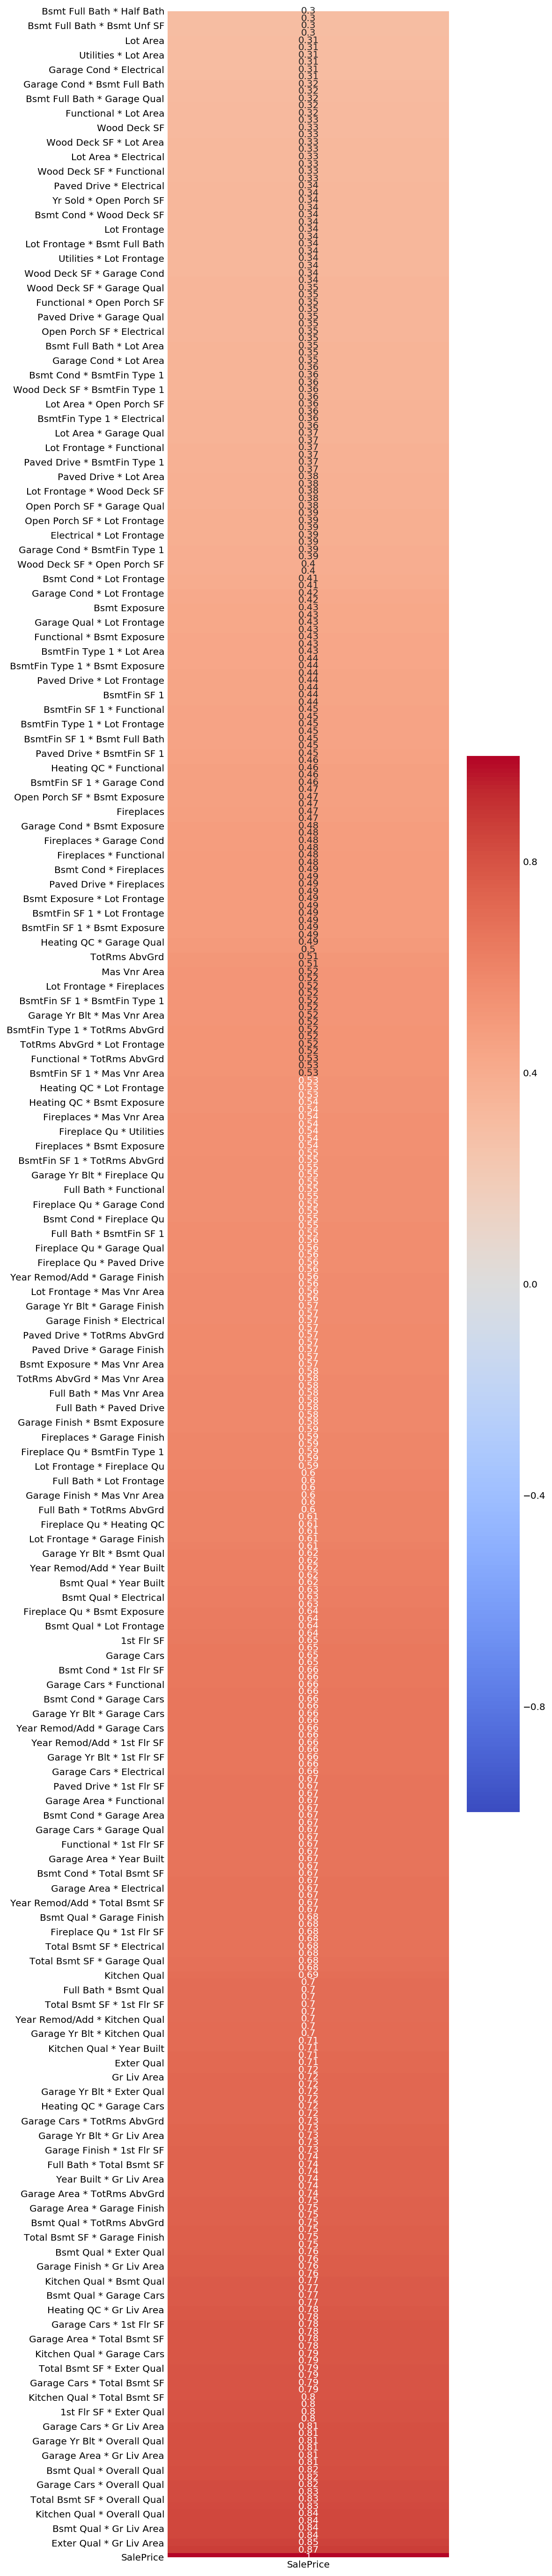

In [1208]:
plt.figure(figsize = (6, 50)) # this figsizes are in inches wide and tall
# need to specify which column you want to sort by, even though there is only 1 column
sns.heatmap(df_train.corr()[['SalePrice']].sort_values('SalePrice'),
            cmap = 'coolwarm',
            vmin = -1,
            vmax = 1,
            annot=True);

In [1209]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047 entries, 109 to 10
Columns: 351 entries, Lot Frontage to SalePrice
dtypes: float64(351)
memory usage: 5.5 MB


## Testing the model

In [1210]:
# Dropping remaining outliers after we tested the models again
df_train.drop([1183, 1783, 2333, 434, 1641, 45], inplace = True)

# from the top
# 182, 1554, 2181, 1499

# from the old linear model, this is what I dropped
# 2181, 1499, 434, 1183, 1783, 2333

In [1211]:
# setting X and y variables
X = df_train.drop(columns = 'SalePrice')
y = df_train['SalePrice']

In [1212]:
#OLS on a test
X_ols = sm.add_constant(X)
est = sm.OLS(y, X.astype(float)).fit()
est.summary()

C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              722.2
Date:                Thu, 16 Jan 2020   Prob (F-statistic):                        0.00
Time:                        17:10:30   Log-Likelihood:                         -22747.
No. Observations:                2041   AIC:                                  4.615e+04
Df Residuals:                    1715   BIC:                                  4.798e+04
Df Model:                         326                                                  
Covariance Type:            nonrobust                                                  
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Lot Frontage                      -54.0047     20.423     -2.644      0.008     -94.060     -13.949
Lot Area                         -101.4467    111.769     -0.908      0.364    -320.665     117.772
Overall Qual                      8.79e+04   8.18e+04      1.074      0.283   -7.26e+04    2.48e+05
Year Built                      -1023.7403   3022.849     -0.339      0.735   -6952.601    4905.120
Year Remod/Add                  -2752.7096   2880.811     -0.956      0.339   -8402.982    2897.563
Mas Vnr Area                     4000.4776   4571.861      0.875      0.382   -4966.534     1.3e+04
Exter Qual                      -2.093e+05   2.01e+05     -1.040      0.299   -6.04e+05    1.86e+05
Bsmt Qual                       -1.178e+05   1.35e+05     -0.872      0.383   -3.83e+05    1.47e+05
Bsmt Exposure                    1.825e+06   6.68e+05      2.733      0.006    5.15e+05    3.13e+06
BsmtFin Type 1                   6977.0378   9324.377      0.748      0.454   -1.13e+04    2.53e+04
BsmtFin SF 1                    -1682.2998   1753.549     -0.959      0.338   -5121.619    1757.020
Total Bsmt SF                     286.4702    415.814      0.689      0.491    -529.086    1102.027
Heating QC                       7831.2280   8971.545      0.873      0.383   -9765.095    2.54e+04
1st Flr SF                       -495.1634    451.457     -1.097      0.273   -1380.628     390.301
Gr Liv Area                      -834.2840    283.527     -2.943      0.003   -1390.379    -278.189
Full Bath                       -5.944e+04   2.47e+04     -2.404      0.016   -1.08e+05   -1.09e+04
Kitchen Qual                    -3.861e+04   1.47e+05     -0.263      0.792   -3.26e+05    2.49e+05
TotRms AbvGrd                    1.893e+05   6.54e+04      2.895      0.004    6.11e+04    3.18e+05
Fireplaces                      -1782.3196   2344.958     -0.760      0.447   -6381.599    2816.960
Fireplace Qu                     3688.9243   2332.142      1.582      0.114    -885.219    8263.067
Garage Yr Blt                    3777.7121   3469.218      1.089      0.276   -3026.632    1.06e+04
Garage Finish                   -2.717e+05   1.27e+05     -2.143      0.032    -5.2e+05    -2.3e+04
Garage Cars                      6.357e+04   1.49e+04      4.272      0.000    3.44e+04    9.28e+04
Garage Area                      1892.4969    774.966      2.442      0.015     372.519    3412.475
Wood Deck SF                      230.2969    100.603      2.289      0.022      32.979     427.615
Open Porch SF                   -7454.2012   1.17e+04     -0.639      0.523   -3.03e+04    1.54e+04
Mas Vnr Area * Lot Frontage         0.0028      0.077      0.037      0.971      -0.

### Train Test Split

In [1213]:
# running Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [1214]:
# Instantiate Standard Scaler.
sc = StandardScaler()

# Fit AND transform Standard Scaler to data in one step.
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [1215]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [1216]:
# plot predictions function
def plot_predictions(predictions, regression_type):

    # plotting training data for Y hat vs actual Y to find outliers
    plt.figure(figsize=(10,5))

    # Generate a scatterplot of carat versus price.
    plt.scatter(predictions,
                y_train,
                alpha = 0.5)

    plt.xlabel('Predicted Sale Price', fontsize = 15)
    plt.ylabel('Actual Sale Price', fontsize = 15)
    plt.title("Predicting Housing Prices with "+regression_type , fontsize = 24)

    # attempting to annot each value
    training = 0
    for i, txt in y_train.iteritems():
        plt.annotate(i, (predictions[training], y_train[i]))
        training += 1

    # plot the regression line
    plt.plot(predictions,
             predictions,
             color = 'red');
    return

### Linear Regression

In [1217]:
# Linear Regression
lr = LinearRegression()
lr.fit(Z_train, y_train_log) # or y_train_log

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1218]:
# predicting values for linear regression
y_hat_lr_train = lr.predict(Z_train) # or y_hat_lr_train_log
y_hat_lr_test = lr.predict(Z_test) # or y_hat_lr_test_log

In [1219]:
# need to test
preds_lr_train = np.exp(y_hat_lr_train)
preds_lr_test = np.exp(y_hat_lr_test)

In [1220]:
print(lr.score(Z_train, y_train_log))
print(lr.score(Z_test, y_test_log))

0.9476305205582094
0.878066818504147


In [1221]:
# this is the 5 fold cross val score
cross_val_score(lr, Z_train, y_train_log, cv=5).mean()

-1.755281247116025e+20

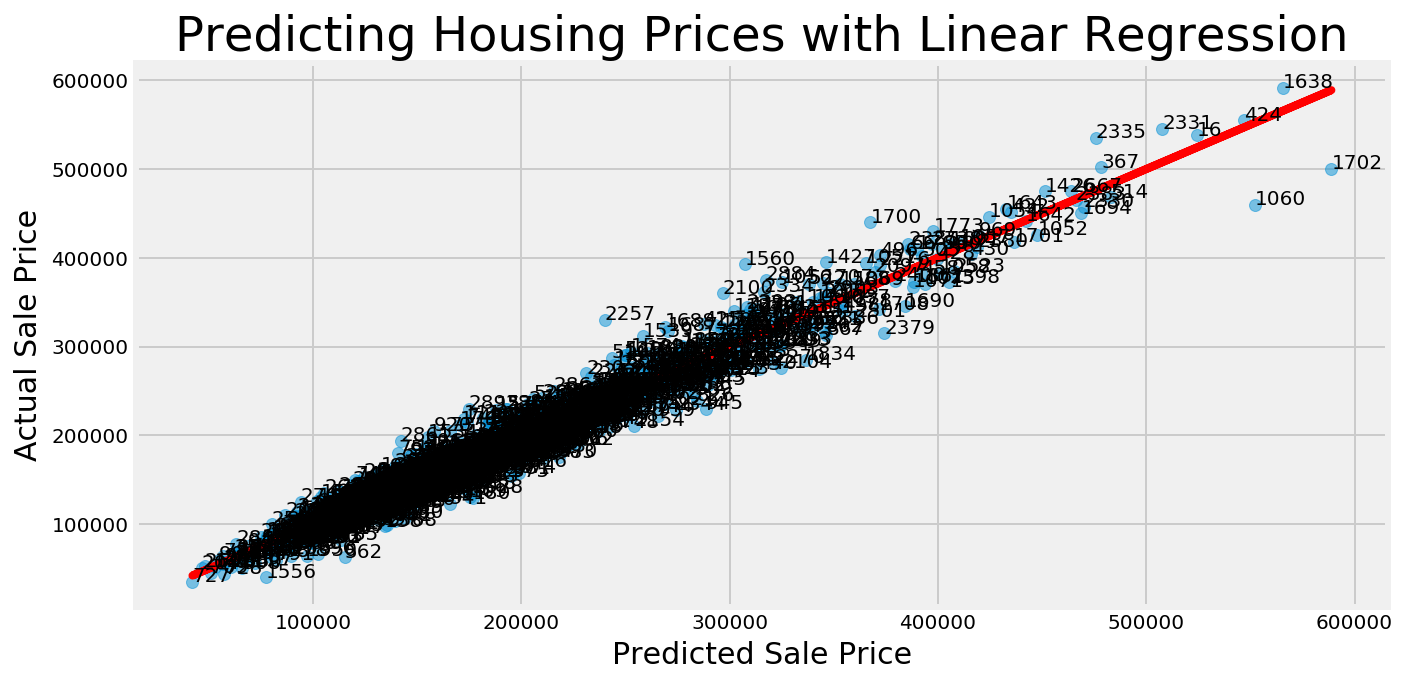

In [1222]:
plot_predictions(preds_lr_train, 'Linear Regression')

In [1223]:
# Mean Squared Errors for Y Training
np.sqrt(mean_squared_error(y_train, preds_lr_train))

16011.524197203327

In [1224]:
# Mean Squared Errors for Y Test
np.sqrt(mean_squared_error(y_test, preds_lr_test))

24589.956423516833

### Ridge Regression ###

In [1225]:
# Set up a list of ridge alphas to check.
# Generates 100 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.
ridge_alphas = np.linspace(61, 65, 100)

# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(
    alphas = ridge_alphas,
    scoring = "r2",
    cv = 5) #How many folds

# Fit model using best ridge alpha!
ridge_cv.fit(Z_train, y_train_log) # or y_train log 

RidgeCV(alphas=array([61.        , 61.04040404, 61.08080808, 61.12121212, 61.16161616,
       61.2020202 , 61.24242424, 61.28282828, 61.32323232, 61.36363636,
       61.4040404 , 61.44444444, 61.48484848, 61.52525253, 61.56565657,
       61.60606061, 61.64646465, 61.68686869, 61.72727273, 61.76767677,
       61.80808081, 61.84848485, 61.88888889, 61.92929293, 61.96969697,
       62.01010101, 62.05050505, 62.09090909, 62...
       64.03030303, 64.07070707, 64.11111111, 64.15151515, 64.19191919,
       64.23232323, 64.27272727, 64.31313131, 64.35353535, 64.39393939,
       64.43434343, 64.47474747, 64.51515152, 64.55555556, 64.5959596 ,
       64.63636364, 64.67676768, 64.71717172, 64.75757576, 64.7979798 ,
       64.83838384, 64.87878788, 64.91919192, 64.95959596, 65.        ]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring='r2',
        store_cv_values=False)

In [1226]:
# Optimal Alpha
ridge_cv.alpha_

63.38383838383838

In [1227]:
print(ridge_cv.score(Z_train, y_train_log))
print(ridge_cv.score(Z_test, y_test_log))

0.9281619542276369
0.9114961720404308


In [1228]:
# fitting
ridge = Ridge(alpha = ridge_cv.alpha_)
ridge.fit(Z_train, y_train_log) # or y_train_log

Ridge(alpha=63.38383838383838, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [1229]:
# predicting values with Ridge
y_hat_ridge_train = ridge.predict(Z_train) # these are log versions
y_hat_ridge_test = ridge.predict(Z_test)

In [1230]:
# Final Ridge predictions
preds_ridge_train = np.exp(y_hat_ridge_train)
preds_ridge_test = np.exp(y_hat_ridge_test)

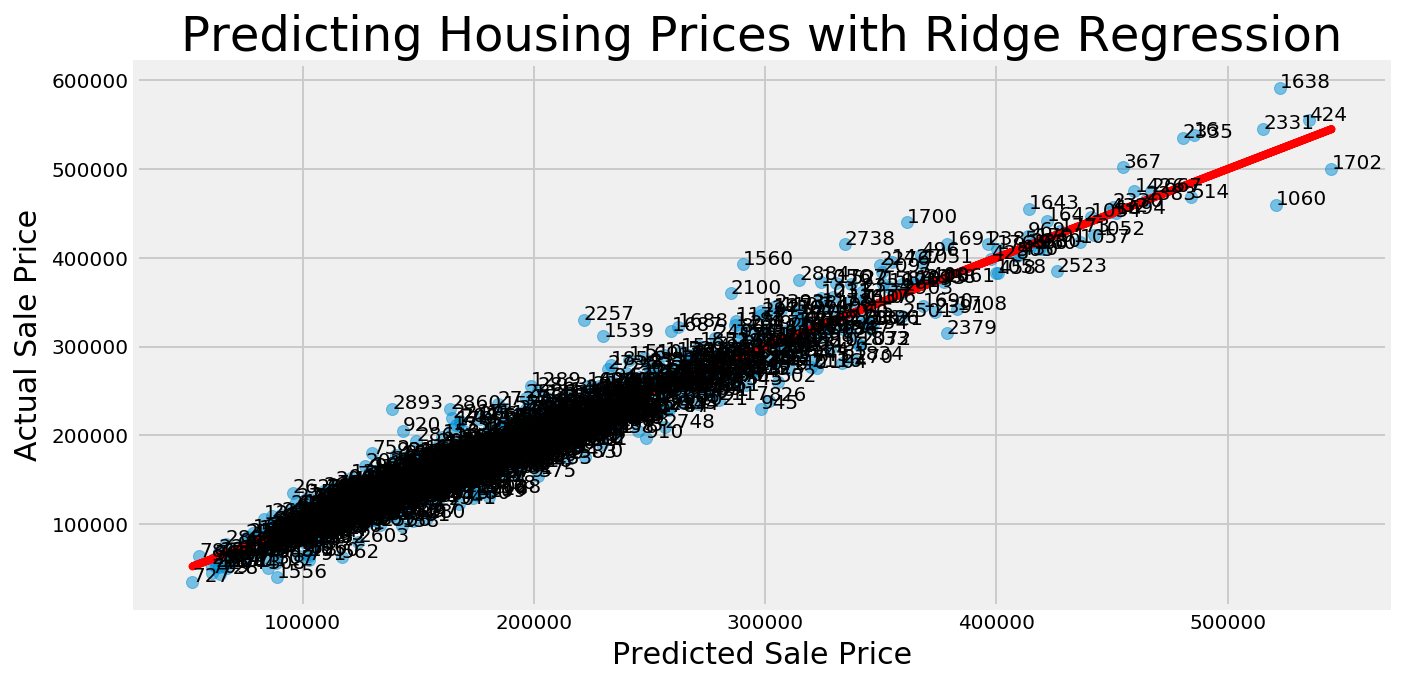

In [1231]:
plot_predictions(preds_ridge_train, 'Ridge Regression')

In [1232]:
# Mean Squared Errors for Y Training
np.sqrt(mean_squared_error(y_train, preds_ridge_train))

18055.73674171544

In [1233]:
# test data linear regression RMSE
np.sqrt(mean_squared_error(y_test, preds_ridge_test)) # keep updating y_test values here for the models

20768.347989909245

### LASSO

In [1234]:
# Set up a list of Lasso alphas to check.
lasso_alphas = np.linspace(0.001, 0.0015, 100)

# Cross-validate over our list of Lasso alphas.
lasso = LassoCV(
    alphas = lasso_alphas,
    cv = 5,
    max_iter = 5000)

# Fit model using best ridge alpha!
lasso.fit(Z_train, y_train_log)

LassoCV(alphas=array([0.001     , 0.00100505, 0.0010101 , 0.00101515, 0.0010202 ,
       0.00102525, 0.0010303 , 0.00103535, 0.0010404 , 0.00104545,
       0.00105051, 0.00105556, 0.00106061, 0.00106566, 0.00107071,
       0.00107576, 0.00108081, 0.00108586, 0.00109091, 0.00109596,
       0.00110101, 0.00110606, 0.00111111, 0.00111616, 0.00112121,
       0.00112626, 0.00113131, 0.00113636, 0.00114141, 0.00114646,
       0.00115...
       0.00142929, 0.00143434, 0.00143939, 0.00144444, 0.00144949,
       0.00145455, 0.0014596 , 0.00146465, 0.0014697 , 0.00147475,
       0.0014798 , 0.00148485, 0.0014899 , 0.00149495, 0.0015    ]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=5000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [1235]:
lasso.alpha_

0.0012525252525252524

In [1236]:
print(lasso.score(Z_train, y_train_log))
print(lasso.score(Z_test, y_test_log))

0.9203571797980936
0.908505465519199


In [1237]:
# predicting logged values with Ridge
y_hat_lasso_train = lasso.predict(Z_train)
y_hat_lasso_test = lasso.predict(Z_test)

In [1238]:
# Final Ridge predictions
preds_lasso_train = np.exp(y_hat_lasso_train)
preds_lasso_test = np.exp(y_hat_lasso_test)

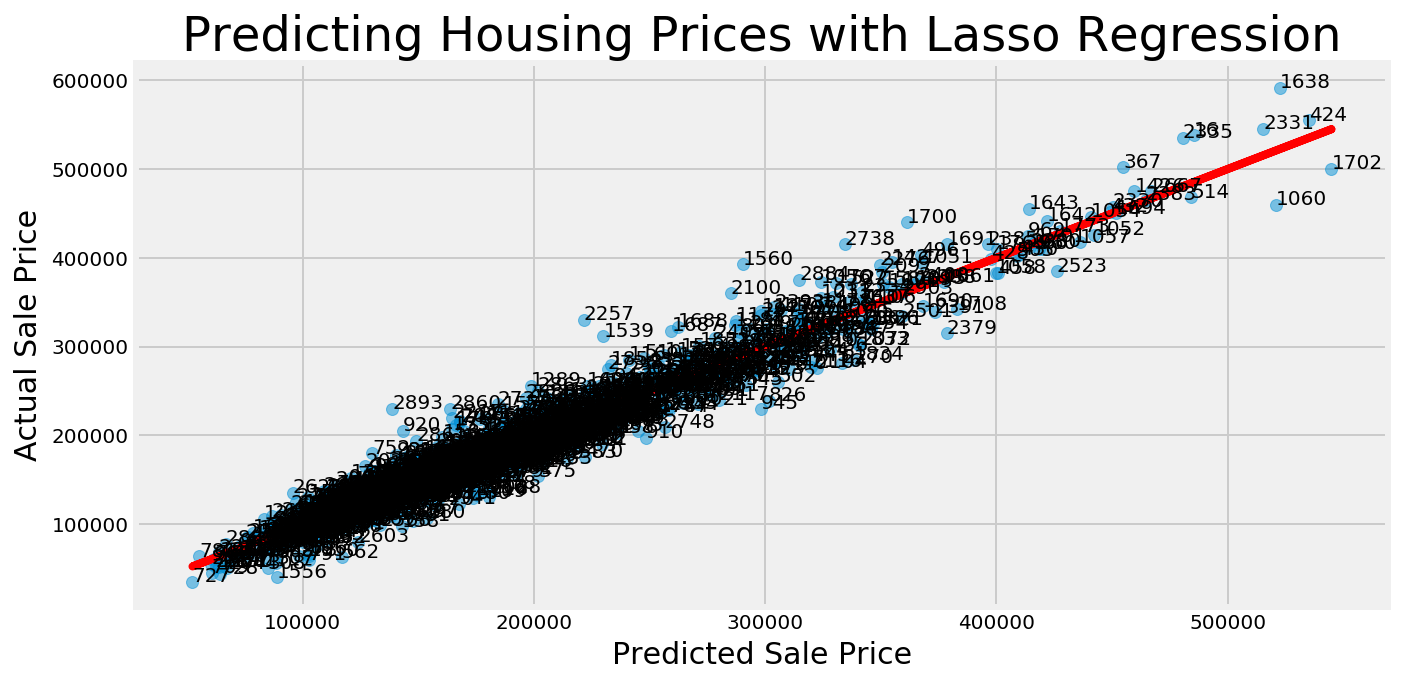

In [1239]:
plot_predictions(preds_ridge_train, 'Lasso Regression')

In [1240]:
# Mean Squared Errors for Y Training
np.sqrt(mean_squared_error(y_train, preds_lasso_train))

19133.537888642975

In [1241]:
# test data linear regression RMSE
np.sqrt(mean_squared_error(y_test, preds_lasso_test))

21095.728346384643

In [1242]:
lasso.coef_

array([-0.00000000e+00, -0.00000000e+00,  7.70010612e-02,  0.00000000e+00,
        1.91905029e-02, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.00801632e-02,  0.00000000e+00,  0.00000000e+00,
        1.71445444e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.15153584e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.46156748e-04, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  1.74090641e-03, -1.02149010e-02,  0.00000000e+00,
       -1.20519434e-02, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        2.36545863e-02,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

### ElasticNet Regression

In [1243]:
# Create the hyperparameter grid (THINK: how many different hyperparameter combinations are there?)
# Hyperparameters for Elastic Net: (1) Alpha, 2 L1_ratio (rho)
hyperparams = {'alpha': [0.01, 0.1, 1, 10, 100], # originally 0.01, 0.1, 10, 100
              'l1_ratio': [0, 0.2, 0.5, 0.7, 1]} # 0, 0.2, 0.5, 0.7, 1

# Instantiated the GridSearch on a Elastic Net model
enet_gs = GridSearchCV(estimator = ElasticNet(), # estimator is the parent model object
                      param_grid = hyperparams,
                      cv = 5) # param_grid is the test cases for hyperparams
enet_gs.fit(Z_train, y_train_log)


# Fit it to data!                (THINK: How many models are going to be fit?)

C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.130328714165318, tolerance: 0.019588307483087552
  positive)
C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.893297048843072, tolerance: 0.01959798810798281
  positive)
C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.469932174191102, tolerance: 0.02008224514242646
  positive)
C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\co

C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.76931833567057, tolerance: 0.019695586148761955
  positive)
C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.85503242029596, tolerance: 0.019434304215979144
  positive)
C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.18679489902108, tolerance: 0.019588307483087552
  positive)
C:\Users\16463\AppData\Local\Continuum\anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0, 0.2, 0.5, 0.7, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [1244]:
# See what the best average CV score is
enet_gs.best_score_

0.9088445305367048

In [1245]:
# See which combination of hyperparameters in the grid resulted in this best score
enet_gs.best_params_

{'alpha': 0.1, 'l1_ratio': 0}

In [1246]:
# Notice we can call this object and use it to predict. Let's call this object best_enet
best_enet = enet_gs.best_estimator_
enet_gs.best_estimator_

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [1247]:
# Use this to make predictions and score them
best_enet.score(Z_test, y_test_log)

0.9093071621893013

In [1248]:
# # need to figure out the optimal l1 ratio

# Set up a list of alphas to check.
# enet_alphas = np.linspace(0.0001, 0.001, 1000)

# # Set up our l1 ratio.
# enet_ratio = 0.5

# # Instantiate model.
# enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5)

# # Fit model using optimal alpha.
# enet_model = enet_model.fit(Z_train, y_train_log)

# # Generate predictions.
# enet_model_preds = enet_model.predict(Z_test)
# enet_model_preds_train = enet_model.predict(Z_train)

# # Evaluate model.
# print(enet_model.score(Z_train, y_train_log))
# print(enet_model.score(Z_test, y_test_log))

In [1249]:
# # Here is the optimal value of alpha.
# enet_model.alpha_

In [1250]:
# # Final Enet Predictions
# preds_enet_train = np.exp(enet_model_preds_train)
# preds_enet_test = np.exp(enet_model_preds)

In [1252]:
# plot_predictions(preds_enet_train, 'Enet Regression')

### Kaggle

In [1253]:
X_kaggle = df_test

In [1254]:
X_kaggle_sc = sc.transform(X_kaggle)

In [1255]:
# Ridge Regression
preds_kaggle_log = ridge.predict(X_kaggle_sc)
X_kaggle['SalePrice'] = np.exp(preds_kaggle_log)

In [1256]:
# # LASSO Regression
# preds_kaggle_log = lr.predict(X_kaggle_sc)
# X_kaggle['SalePrice'] = np.exp(preds_kaggle_log)

In [1257]:
# # Enet Regression
# preds_kaggle_log = enet_model.predict(X_kaggle_sc)
# X_kaggle['SalePrice'] = np.exp(preds_kaggle_log)

In [1258]:
output = X_kaggle[['SalePrice']]

In [1259]:
# Creating CSV file
output.to_csv('./datasets/RidgeRegression_CorrelationsAbove0.3_324InteractionsAdded_1NominalDummy_10OutliersRemoved.csv')